# Example: noisy identity process on one qubit

This example is featured in the paper.


**Contents:**
* [Python initializations](#Python-initializations)
* [Data set-up](#Data-set-up)
* [Bipartite sampling method](#Bipartite-sampling-method)
* [Bipartite sampling method, optimized](#Bipartite-sampling-method,-optimized)
* [Fit with our empirical model \#2](#Fit-with-our-empirical-model-#2)
* [Bipartite sampling method, optimize, entanglement fidelity](#Bipartite-sampling-method,-optimized,-entanglement-fidelity)
* [Bipartite sampling method, optimize, worst-case entanglement fidelity](#Bipartite-sampling-method,-optimized,-worst-case-entanglement-fidelity)
* [Prepare data for channel-space methods](#Prepare-data-for-channel-space-methods)
* [Channel-space method, "$e^{iH}$" variant](#Channel-space-method,-%22$e^{iH}$%22-variant)
* [Channel-space method, "elementary rotations" variant](#Channel-space-method,-%22elementary-rotation%22-variant)
* [Channel-space method, "elementary rotations" variant, entanglement fidelity](#Channel-space-method,-%22elementary-rotation%22-variant,-entanglement-fidelity)
* [Channel-space method, "elementary rotations" variant, worst-case entanglement fidelity](#Channel-space-method,-%22elementary-rotation%22-variant,-worst-case-entanglement-fidelity)
* [Grand comparison plots](#Grand-comparison-plots)


## Python initializations

In [1]:
from __future__ import print_function
import os.path
import sys
import datetime

import numpy as np
import numpy.linalg as npl

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
matplotlib.rc('font', family='Arial')

from IPython.display import display, Markdown, Latex

import dnormtomo.channelspace
import dnormtomo.bistates
import dnormtomo.util

# use this to load pickle files saved with our old python code
sys.modules['pydnorm_util'] = dnormtomo.util
dnormtomo.util._Ns = dnormtomo.util._Store

import qutip

import tomographer
import tomographer.jpyutil
import tomographer.querrorbars
display(Markdown("Using `dnormtomo` **{}** with `tomographer` **{}**"
                 .format(dnormtomo.__version__, tomographer.__version__)))

# to save & load computation results
try:
    import cPickle as pickle
except:
    import pickle

# interact with plots in notebook
%matplotlib notebook

Using `dnormtomo` **0.9** with `tomographer` **v5.3-65-g44f6a8d**

In [2]:
# utilities for storing & loading calculation results
def save_to_cache(cachesuffix, x):
    with open('_CACHE_'+cachesuffix+'.dat', 'wb') as f:
        pickle.dump(x, f, 2)
def load_from_cache(cachesuffix):
    cachefile = '_CACHE_'+cachesuffix+'.dat'
    if not os.path.exists(cachefile):
        return None
    with open(cachefile, 'rb') as f:
        display(Markdown("Loading `{}` from cache".format(cachesuffix)))
        return pickle.load(f)

## Data set-up

In [3]:
#
# number of outcomes per Pauli pairs
#
NumSamplesPerSetting = 5000
# Pauli measurement settings on one system
PauliMeasSettings = [
    [
        dnormtomo.util.projpauli(i, s)
        for s in [1, -1]
    ]
    for i in [1, 2, 3]
]
# simulate the measurements
sigmareal_X = qutip.Qobj(np.array([[ 0.6, 0.01], [0.01, 0.4]]))
Ereal_XY = qutip.Qobj(np.array([[ 0.95, 0, 0, 0.95],
                                [ 0, 0.05, 0, 0],
                                [ 0, 0,    0, 0],
                                [ 0.95, 0, 0, 1],
                               ]), dims=[[2,2],[2,2]])
def simulate_measurements():
    d = dnormtomo.util.simulate_process_measurements(sigmareal_X, Ereal_XY, PauliMeasSettings, PauliMeasSettings,
                                                     NumSamplesPerSetting)
    
    with open('meas_data.dat', 'wb') as f:
        pickle.dump(d, f)
        
    return d

#
# Only simulate the measurements once. After that, use the same data when comparing methods!!
#
if not os.path.exists('meas_data.dat'):
    d = simulate_measurements()
else:
    with open('meas_data.dat', 'rb') as f:
        d = pickle.load(f)

#print(d.__dict__) # should print Emn, Nm

#
# Only simulate the measurements once. After that, use the same data when comparing methods!!
#
d = load_from_cache('meas_data')
if d is None:
    d = simulate_measurements()
    save_to_cache('meas_data', d)

display(Markdown("We have **{}** total measurements".format(sum(d.Nm))))

#print(d.__dict__) # prints Emn, Nm ... long outputs!!

Loading `meas_data` from cache

We have **45000** total measurements

In [4]:
#
# Stuff for the analysis, later
#

def print_report(r):
    display(Markdown("Calculation ran for **{!s} seconds**".format(datetime.timedelta(seconds=r['elapsed_seconds']))))
    display(Markdown("```\n{}\n```".format(r['final_report_runs'])))

def do_analysis(r, name, plots=False, ftox=(0,1), qtyname='diamond distance'):
    final_histogram = r['final_histogram']
    analysis = tomographer.querrorbars.HistogramAnalysis(final_histogram, ftox=ftox)
    fitparams = analysis.printFitParameters()
    analysis.printQuantumErrorBars()
    
    p1 = None
    p2 = None
    
    if plots:
        p1 = analysis.plot(show_plot=False) # linear scale
        p1.ax.set_title("Distribution of the %s: %s"%(qtyname, name))
        p1.ax.set_xlabel('Diamond Norm distance to the identity channel')
        p1.show()

        p2 = analysis.plot(log_scale=True, show_plot=False) # log scale
        p2.ax.set_title("Distribution of the %s: %s"%(qtyname, name))
        p2.ax.set_xlabel('Diamond Norm distance to the identity channel')
        p2.show()
    
    return {'r': r, 'name': name, 'analysis': analysis, 'fitparams': fitparams, 'p1': p1, 'p2': p2}



## Bipartite sampling method

In [5]:
r_naive = load_from_cache('r_naive')
if r_naive is None:
    # perform calculation
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_naive = dnormtomo.bistates.run(
            dimX=2, dimY=2, Emn=d.Emn, Nm=np.array(d.Nm),
            hist_params=tomographer.HistogramParams(0, 0.2, 50),
            mhrw_params=tomographer.MHRWParams(0.008, 125, 2048, 32768),
            progress_fn=prg.progress_fn
            )
        prg.displayFinalInfo(r_naive['final_report_runs'])
    save_to_cache('r_naive', r_naive)

print_report(r_naive)

Loading `r_naive` from cache

Calculation ran for **0:03:19.880226 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.008
	# iter. / sweep = 125
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0|          ..-%#o...                               |0.2                   [accept ratio = 0.25]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0|          ..-%#o....                              |0.2                   [accept ratio = 0.26]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#2: 0|           .-%#o....                              |0.2                   [accept ratio = 0.26]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0|          ..-%#o...                               |0.2                   [accept ratio = 0.26]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 3.64641e-16
          a1 = 3378.25
           m = 193.345
           c = 751.008
Quantum Error Bars:
          f0 = 0.05723
       Delta = 0.005821
       gamma = 0.0001973



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


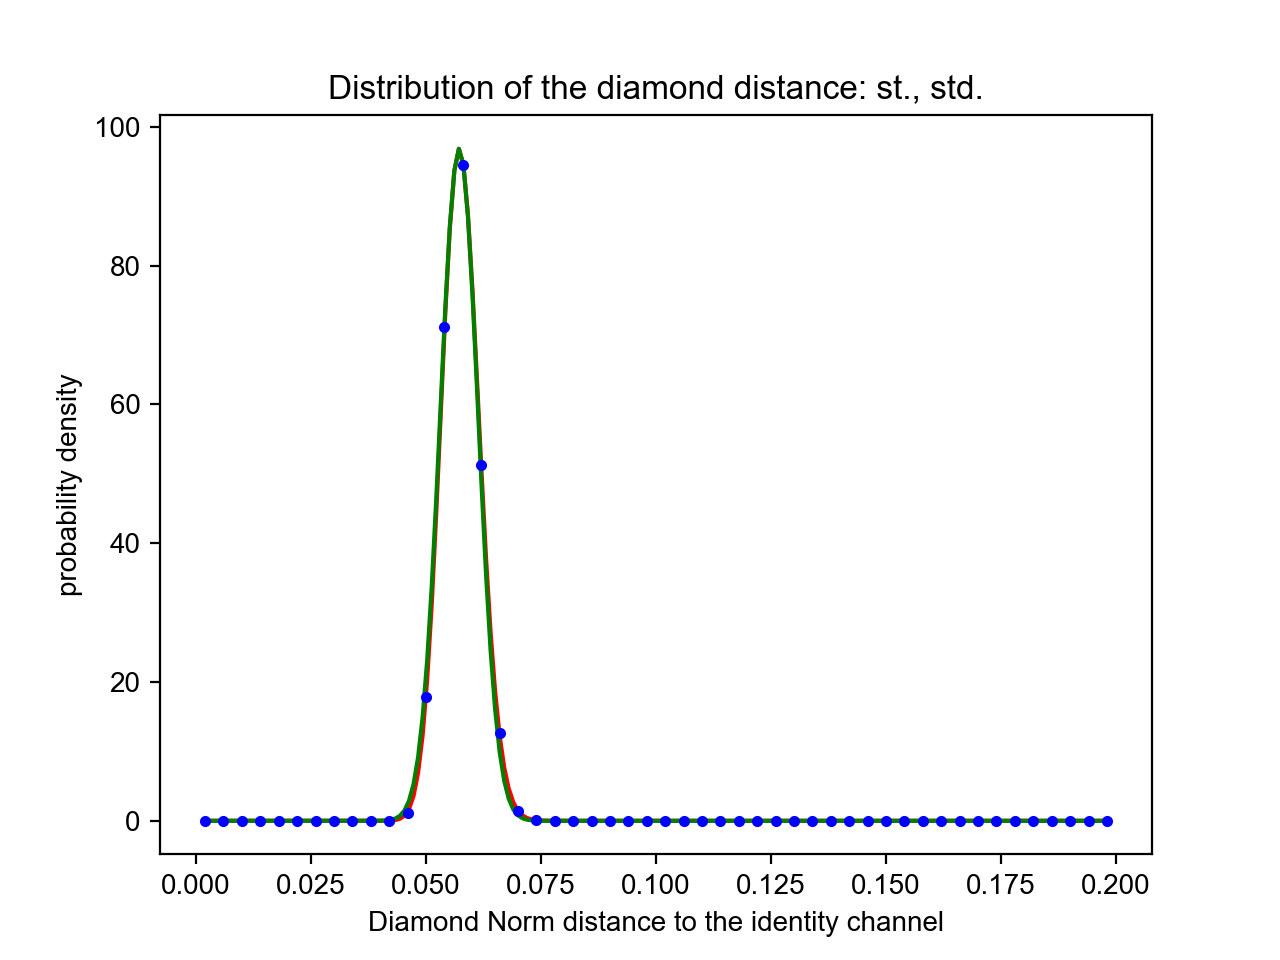

<IPython.core.display.Javascript object>


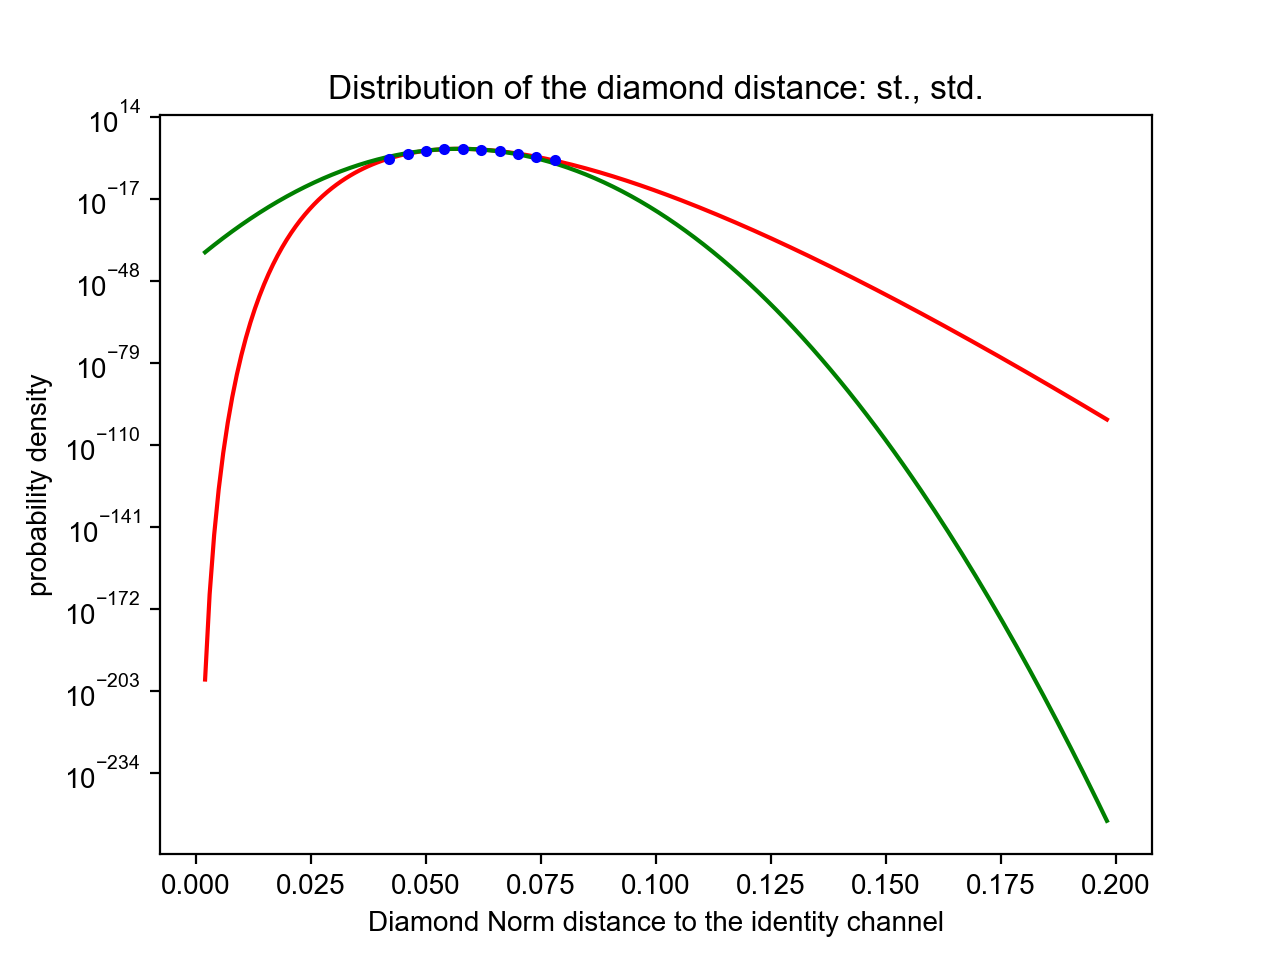

In [56]:
a_naive = do_analysis(r_naive, 'st., std.', plots=True)

## Bipartite sampling method, optimized

In [7]:
r_naiveopt = load_from_cache('r_naiveopt')
if r_naiveopt is None:
    # perform calculation 
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_naiveopt = dnormtomo.bistates.run(
            dimX=2, dimY=2, Emn=d.Emn, Nm=np.array(d.Nm),
            hist_params=tomographer.HistogramParams(0, 0.2, 50),
            mhrw_params=tomographer.MHRWParams(0.008, 512, 32768, 32768), # thermalize a lot
            progress_fn=prg.progress_fn,
            jumps_method='light' # use optimized random walk
            )
        prg.displayFinalInfo(r_naiveopt['final_report_runs'])
    save_to_cache('r_naiveopt', r_naiveopt)

print_report(r_naiveopt)

Loading `r_naiveopt` from cache

Calculation ran for **3:59:31.286247 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.008
	# iter. / sweep = 512
	# therm. sweeps = 32768
	# run sweeps    = 32768
#0: 0|          ..-%#o....                              |0.2                   [accept ratio = 0.28]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0|          ..-%#o....                              |0.2                   [accept ratio = 0.27]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0|          ..-%#o....                              |0.2                   [accept ratio = 0.29]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#3: 0|          ..-%#o...                               |0.2                   [accept ratio = 0.28]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 0.0158744
          a1 = 3342.76
           m = 191.305
           c = 743.136
Quantum Error Bars:
          f0 = 0.05723
       Delta = 0.005852
       gamma = 0.0001994



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


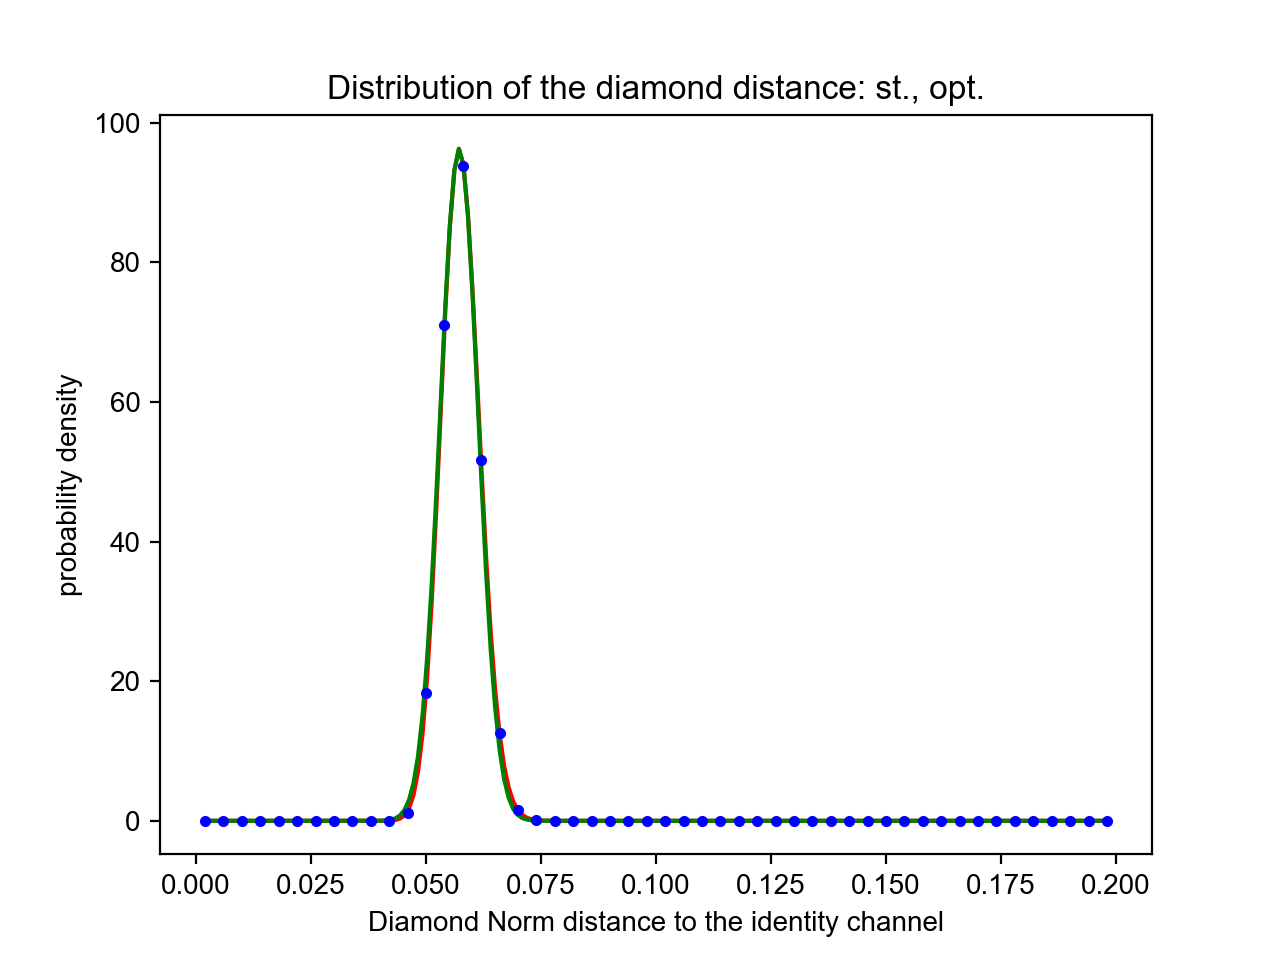

<IPython.core.display.Javascript object>


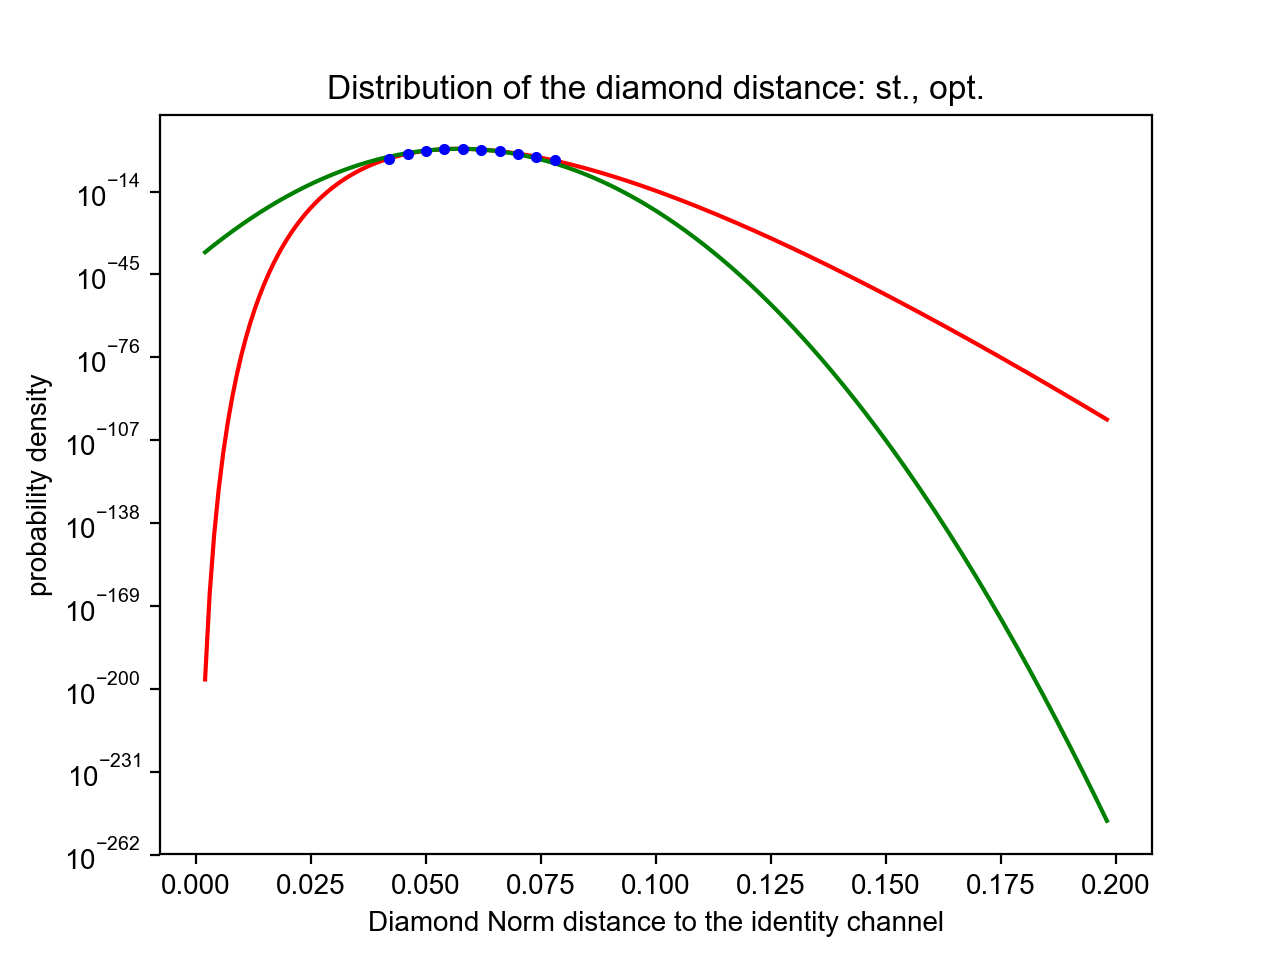

In [32]:
a_naiveopt = do_analysis(r_naiveopt, 'st., opt.', plots=True)

## Bipartite sampling method, optimized, entanglement fidelity

In [9]:
r_Fe_naiveopt = load_from_cache('r_Fe_naiveopt')
if r_Fe_naiveopt is None:
    # perform calculation 
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_Fe_naiveopt = dnormtomo.bistates.run(
            dimX=2, dimY=2, Emn=d.Emn, Nm=np.array(d.Nm),
            fig_of_merit='entanglement-fidelity',
            hist_params=tomographer.HistogramParams(0.9, 1.0, 50),
            mhrw_params=tomographer.MHRWParams(0.008, 512, 32768, 32768), # thermalize a lot
            progress_fn=prg.progress_fn,
            jumps_method='light' # use optimized random walk
            )
        prg.displayFinalInfo(r_Fe_naiveopt['final_report_runs'])
    save_to_cache('r_Fe_naiveopt', r_Fe_naiveopt)

print_report(r_Fe_naiveopt)

Loading `r_Fe_naiveopt` from cache

Calculation ran for **3:40:27.302127 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.008
	# iter. / sweep = 512
	# therm. sweeps = 32768
	# run sweeps    = 32768
#0: 0.9|                         ...o##+..                |1                   [accept ratio = 0.28]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0.9|                         ...o##+...               |1                   [accept ratio = 0.29]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0.9|                         ...o##+...               |1                   [accept ratio = 0.28]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#3: 0.9|                        ....o##+..                |1                   [accept ratio = 0.26]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 43580.1
          a1 = 1028.37
           m = 181.468
           c = 700.169
Quantum Error Bars:
          f0 = 0.9599
       Delta = 0.003163
       gamma = 4.689e-05



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


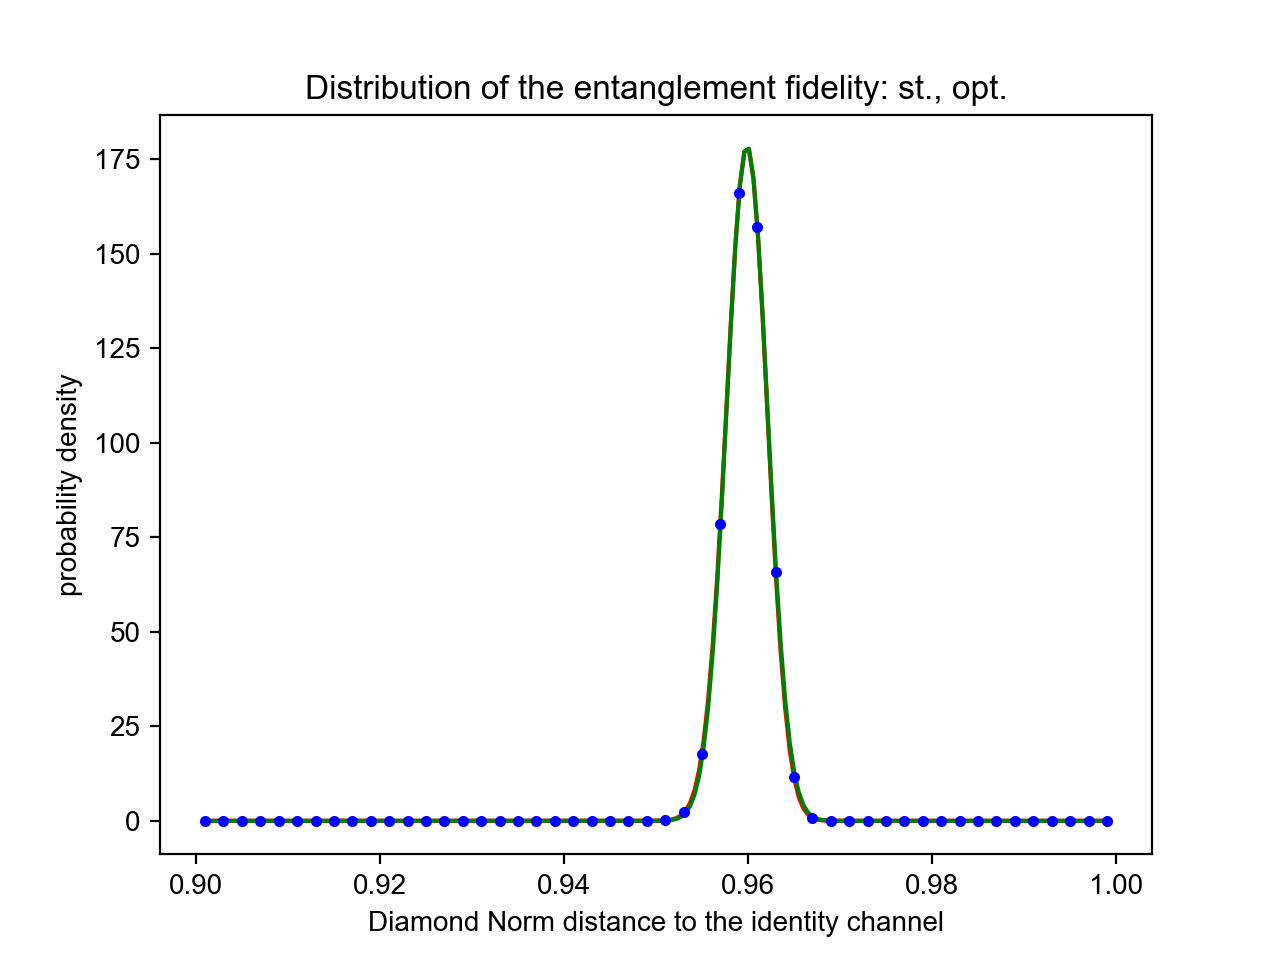

<IPython.core.display.Javascript object>


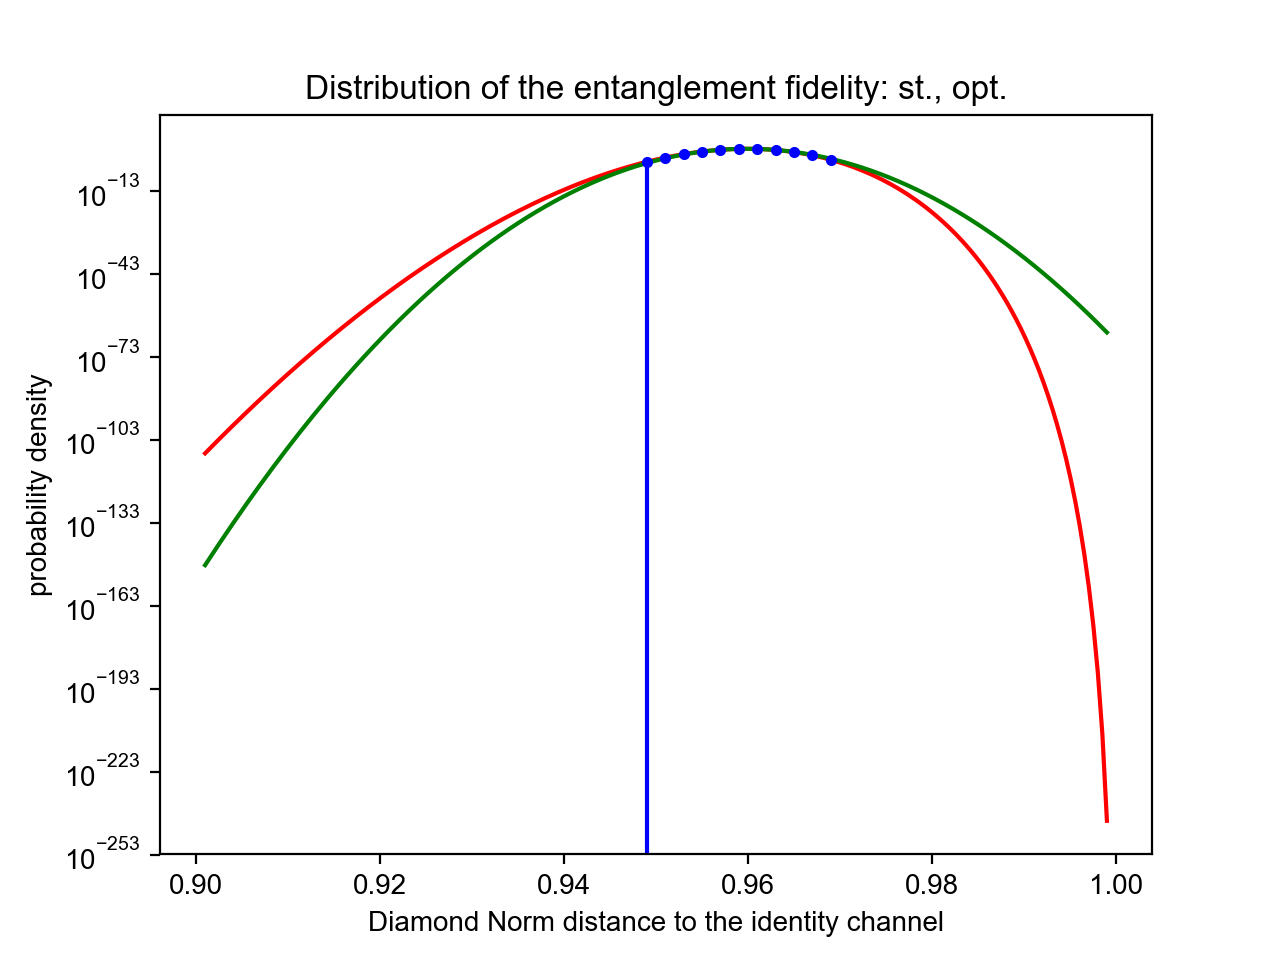

In [33]:
a_Fe_naiveopt = do_analysis(r_Fe_naiveopt, 'st., opt.', plots=True,
                            qtyname='entanglement fidelity', ftox=(1,-1))

## Bipartite sampling method, optimized, worst-case entanglement fidelity

In [11]:
r_wFe_naiveopt = load_from_cache('r_wFe_naiveopt')
if r_wFe_naiveopt is None:
    # perform calculation 
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_wFe_naiveopt = dnormtomo.bistates.run(
            dimX=2, dimY=2, Emn=d.Emn, Nm=np.array(d.Nm),
            fig_of_merit='worst-entanglement-fidelity',
            hist_params=tomographer.HistogramParams(0.85, 1.0, 50),
            mhrw_params=tomographer.MHRWParams(0.008, 512, 32768, 1024), # thermalize a lot
            progress_fn=prg.progress_fn,
            jumps_method='light' # use optimized random walk
            )
        prg.displayFinalInfo(r_Fe_naiveopt['final_report_runs'])
    save_to_cache('r_wFe_naiveopt', r_wFe_naiveopt)

print_report(r_wFe_naiveopt)

Loading `r_wFe_naiveopt` from cache

Calculation ran for **3:40:14.105984 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.008
	# iter. / sweep = 512
	# therm. sweeps = 32768
	# run sweeps    = 1024
#0: 0.85|                          ...+x##+.               |1                  [accept ratio = 0.29]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0.85|                          ...+x#%+..              |1                  [accept ratio = 0.25]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0.85|                           ..-%#%+..              |1                  [accept ratio = 0.31]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#3: 0.85|                           ..+x#%-..              |1                  [accept ratio = 0.28]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 4.42466e-08
          a1 = 3444.16
           m = 189.962
           c = 745.001
Quantum Error Bars:
          f0 = 0.9448
       Delta = 0.005659
       gamma = 0.0001936



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


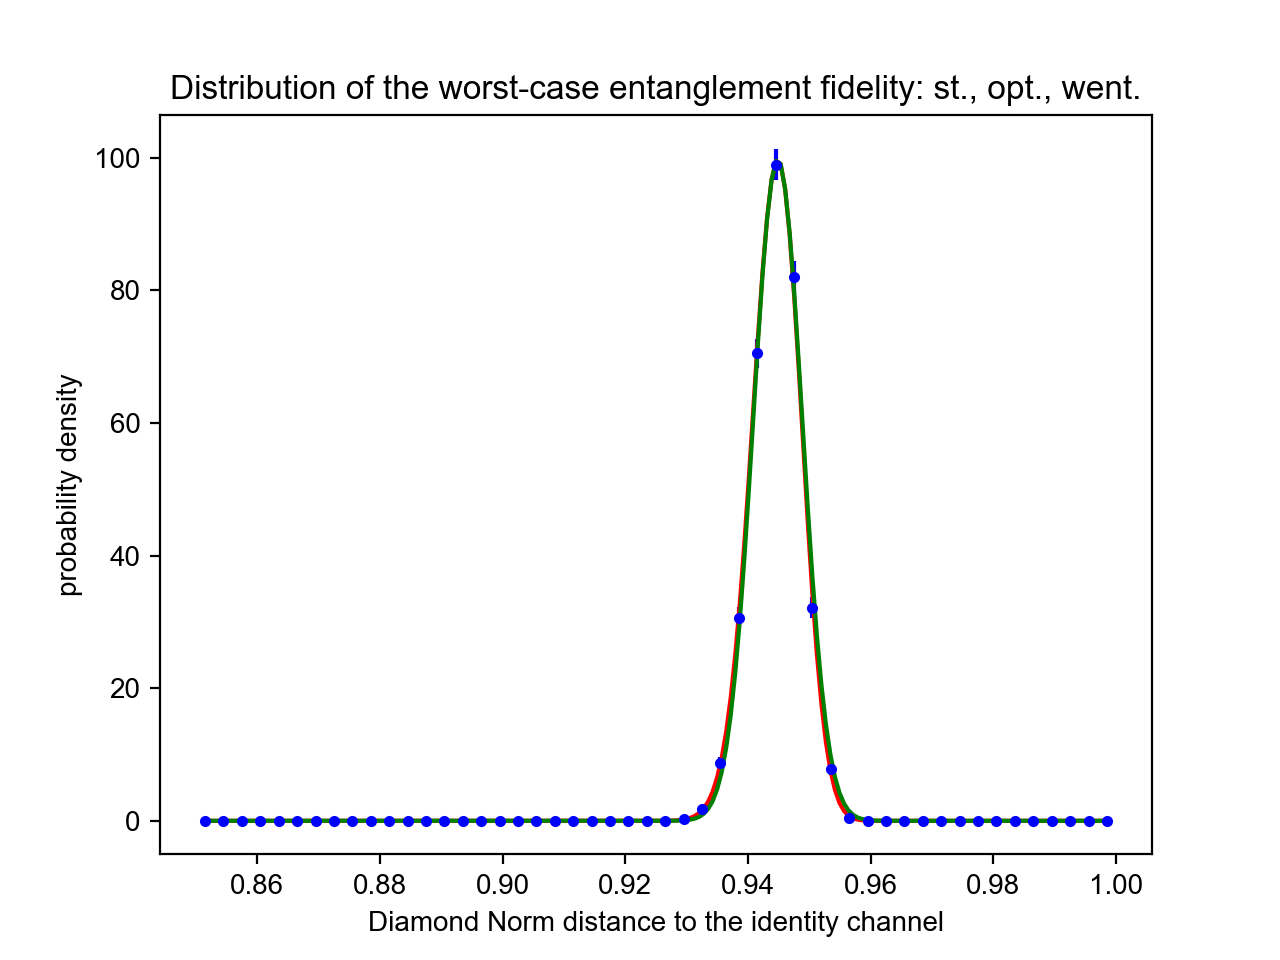

<IPython.core.display.Javascript object>


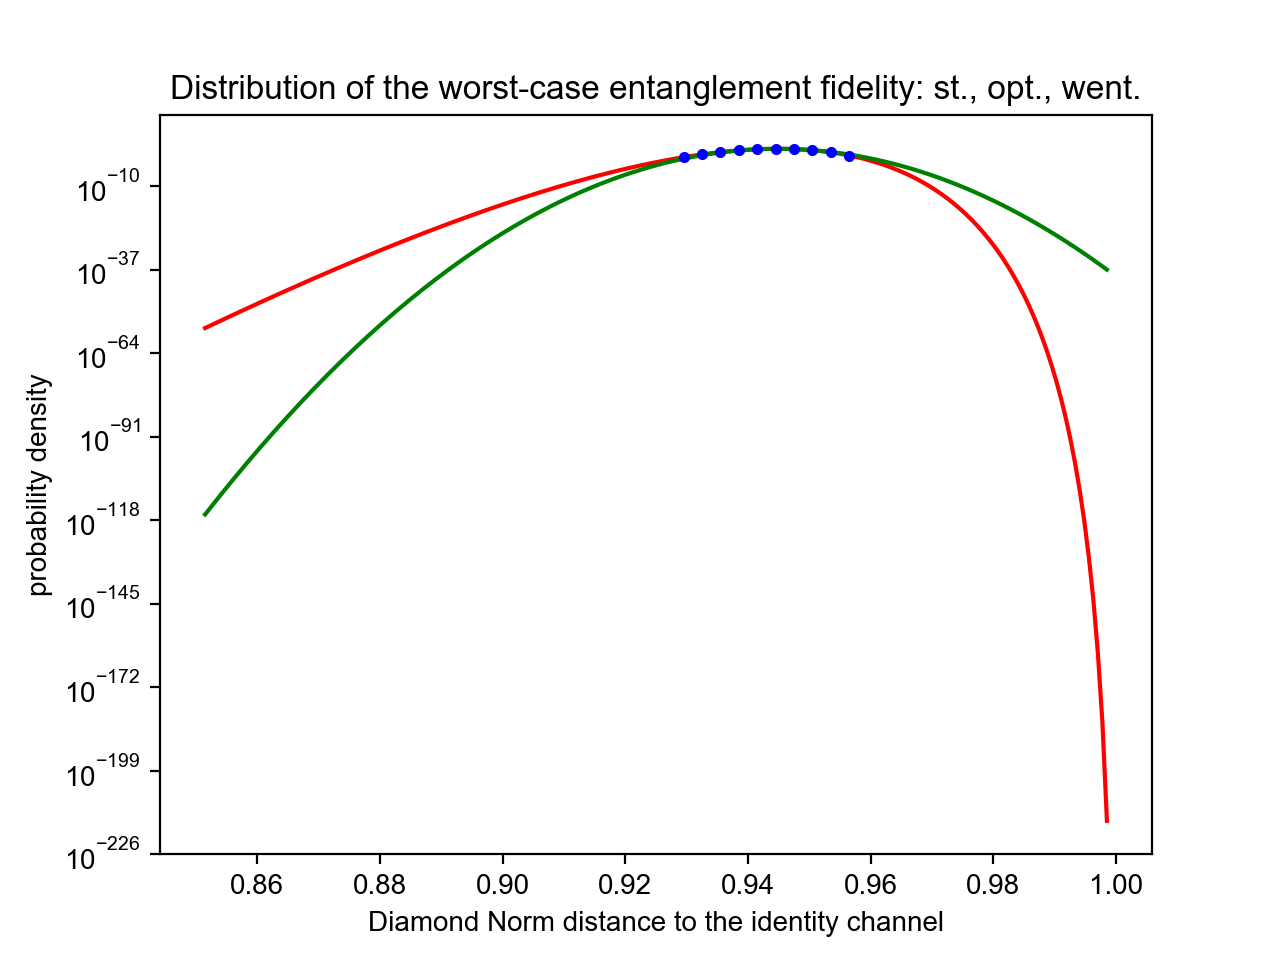

In [45]:
a_wFe_naiveopt = do_analysis(r_wFe_naiveopt, 'st., opt., went.', plots=True,
                             qtyname='worst-case entanglement fidelity', ftox=(1,-1))

## Prepare data for channel-space methods

In [13]:
# we need to encode the input state in the POVM effects

sigmareal_X_sqrtm_eyeY = np.kron(sigmareal_X.sqrtm().data.toarray(), np.eye(2))
Emn_for_channelspace = [
    np.dot(np.dot(sigmareal_X_sqrtm_eyeY, E), sigmareal_X_sqrtm_eyeY)
    for E in d.Emn
]

## Channel-space method, "$e^{iH}$" variant

In [14]:
r_eiH = load_from_cache('r_eiH')
if r_eiH is None:
    # no stored result, perform computation
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_eiH = dnormtomo.channelspace.run(
            dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
            hist_params=tomographer.HistogramParams(0, 0.2, 50),
            channel_walker_jump_mode=dnormtomo.channelspace.RandHermExp,
            mhrw_params=tomographer.MHRWParams(0.01, 100, 2048, 32768),
            progress_fn=prg.progress_fn
            )
        prg.displayFinalInfo(r_eiH['final_report_runs'])
    save_to_cache('r_eiH', r_eiH)
print_report(r_eiH)

Loading `r_eiH` from cache

Calculation ran for **0:14:58.628904 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.01
	# iter. / sweep = 100
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0|          ...x#x-...                              |0.2                   [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0|           ..x#x-..                               |0.2                   [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#2: 0|           ..x#x-..                               |0.2                   [accept ratio = 0.24]
    error bars: 48 converged / 2 maybe (2 isolated) / 0 not converged
#3: 0|          ...x#x-...                              |0.2                   [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 0.00135496
          a1 = 3428.76
           m = 198.235
           c = 767.881
Quantum Error Bars:
          f0 = 0.05782
       Delta = 0.005807
       gamma = 0.0001944



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


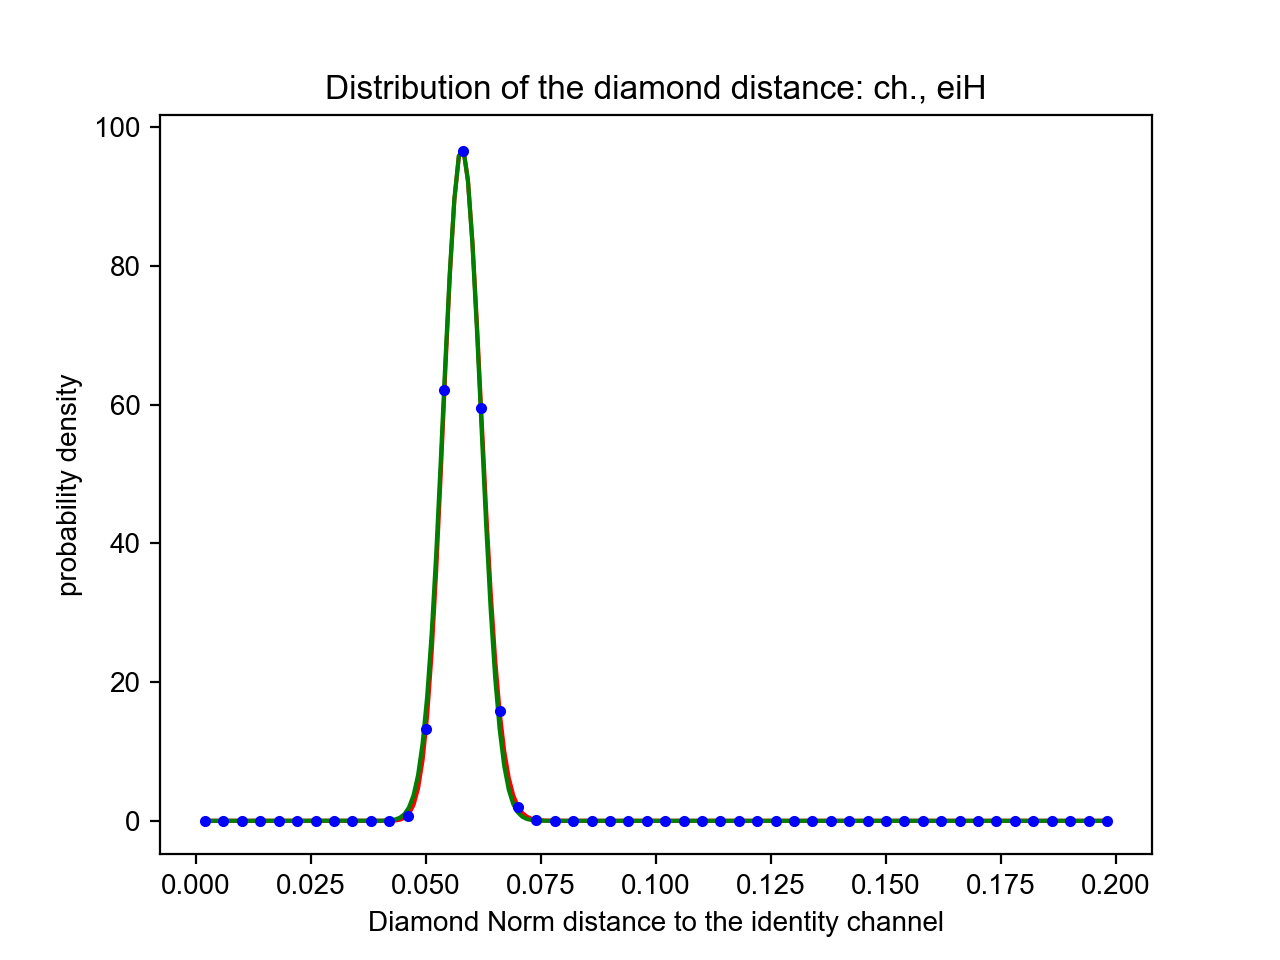

<IPython.core.display.Javascript object>


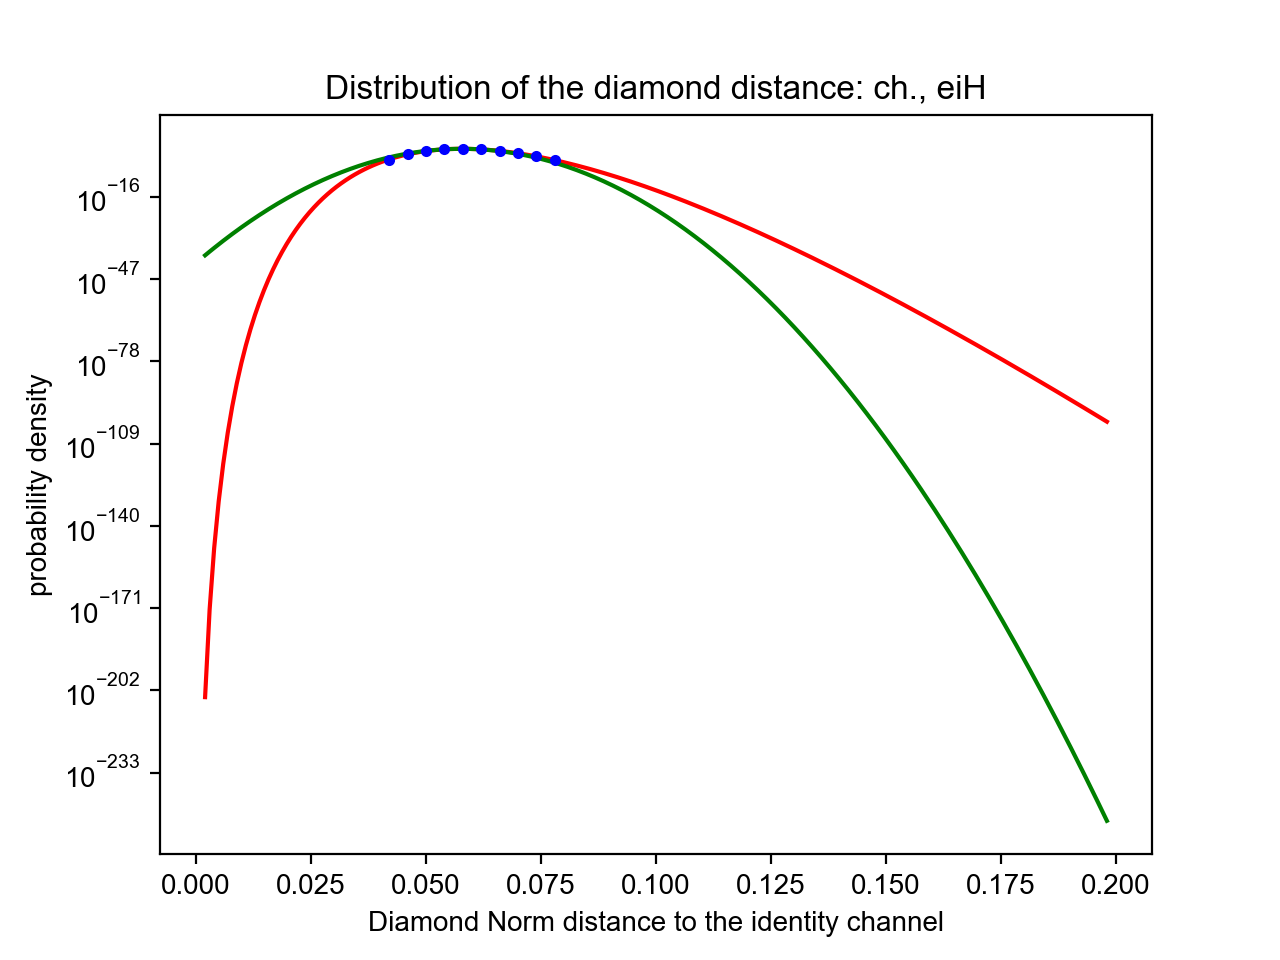

In [34]:
a_eiH = do_analysis(r_eiH, 'ch., eiH',plots=True)

## Channel-space method, "elementary-rotation" variant

In [16]:
r_elr = load_from_cache('r_elr')
if r_elr is None:
    # no stored result, perform computation
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_elr = dnormtomo.channelspace.run(
            dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
            hist_params=tomographer.UniformBinsHistogramParams(0, 0.2, 50),
            channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
            mhrw_params=tomographer.MHRWParams(0.02, 50, 2048, 32768),
            progress_fn=prg.progress_fn
            )
        prg.displayFinalInfo(r_elr['final_report_runs'])
    save_to_cache('r_elr', r_elr)
print_report(r_elr)

Loading `r_elr` from cache

Calculation ran for **0:09:13.172125 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.02
	# iter. / sweep = 50
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0|           .-x#x-..                               |0.2                   [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0|           ..x#x-...                              |0.2                   [accept ratio = 0.25]
    error bars: 49 converged / 0 maybe (0 isolated) / 1 not converged
#2: 0|          ...x#x-..                               |0.2                   [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0|           ..x#x-..                               |0.2                   [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 3.56162e-10
          a1 = 3421.27
           m = 197.843
           c = 766.328
Quantum Error Bars:
          f0 = 0.05783
       Delta = 0.005814
       gamma = 0.0001949



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


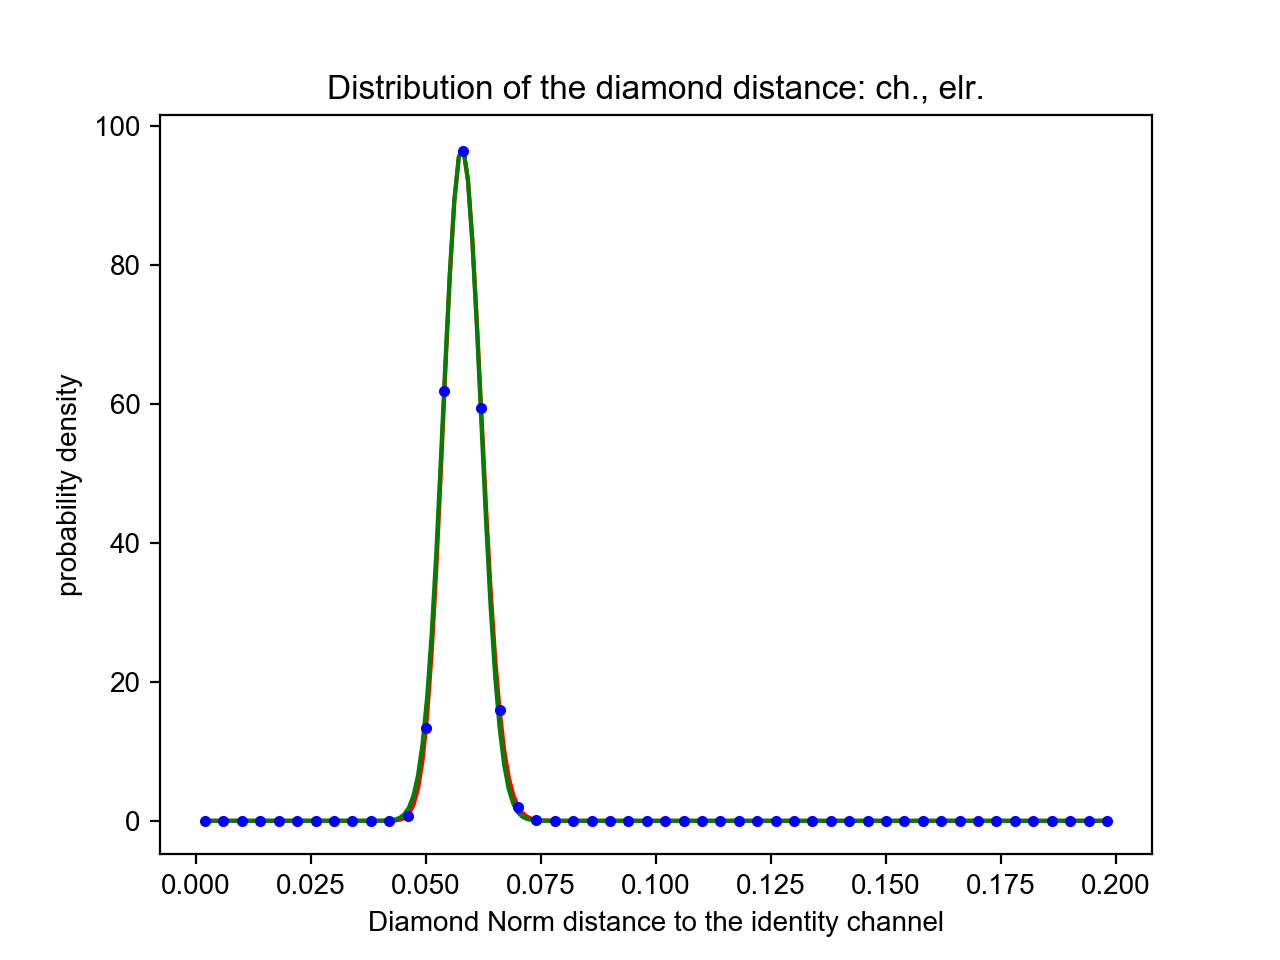

<IPython.core.display.Javascript object>


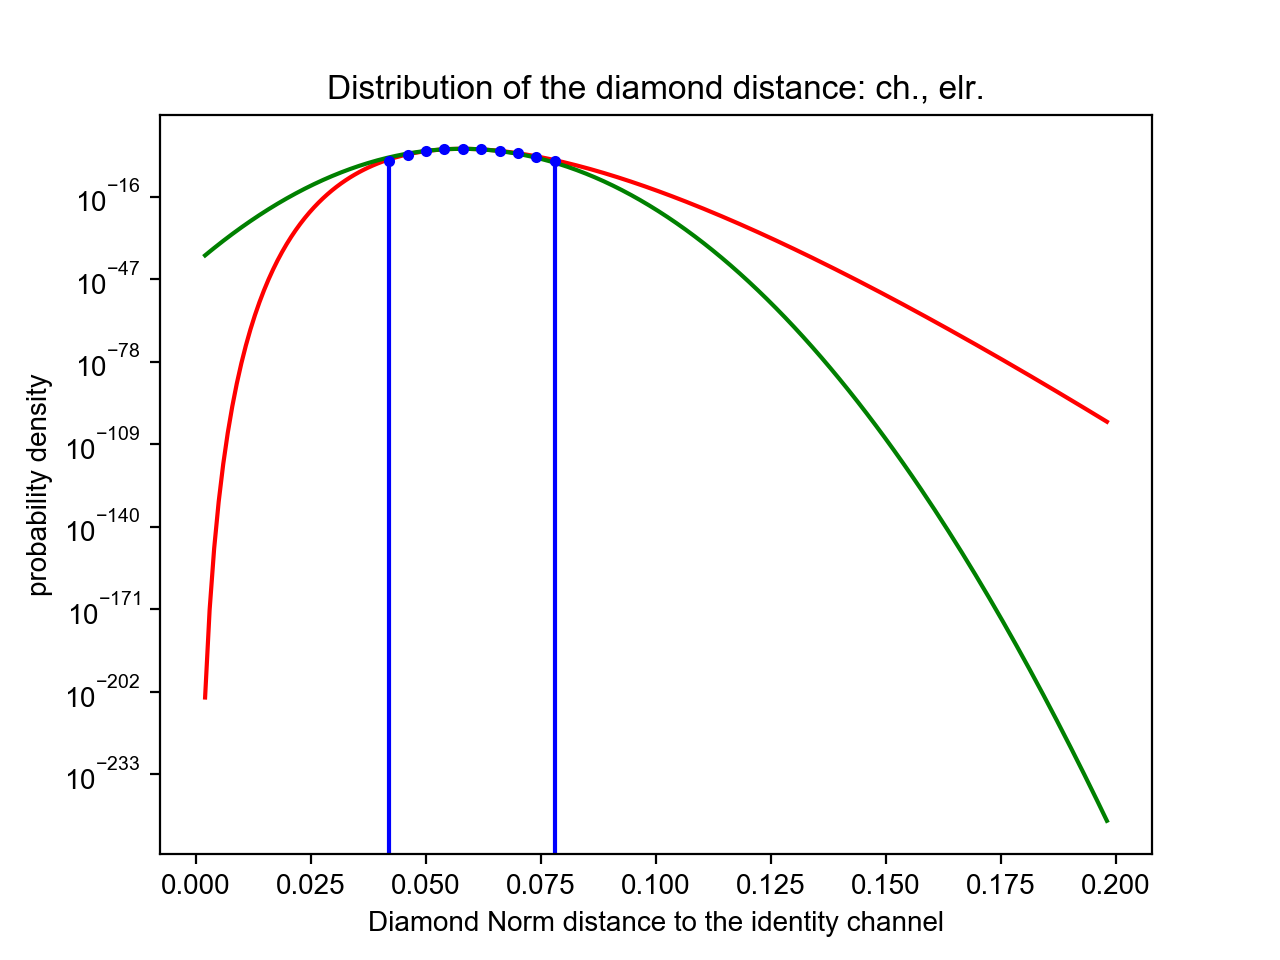

In [35]:
a_elr = do_analysis(r_elr, 'ch., elr.', plots=True)

## Channel-space method, "elementary-rotation" variant, entanglement fidelity

In [18]:
r_Fe_elr = load_from_cache('r_Fe_elr')
if r_Fe_elr is None:
    # no stored result, perform computation
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_Fe_elr = dnormtomo.channelspace.run(
            dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
            fig_of_merit='entanglement-fidelity',
            hist_params=tomographer.UniformBinsHistogramParams(0.9, 1.0, 50),
            channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
            mhrw_params=tomographer.MHRWParams(0.02, 50, 2048, 32768),
            progress_fn=prg.progress_fn
            )
        prg.displayFinalInfo(r_Fe_elr['final_report_runs'])
    save_to_cache('r_Fe_elr', r_Fe_elr)
print_report(r_Fe_elr)

Loading `r_Fe_elr` from cache

Calculation ran for **0:06:09.274538 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.02
	# iter. / sweep = 50
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0.9|                         ...o##+...               |1                   [accept ratio = 0.25]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0.9|                         ...o##+...               |1                   [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#2: 0.9|                         ...o##+..                |1                   [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0.9|                        ....o##+..                |1                   [accept ratio = 0.25]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 38072.2
          a1 = 2211.99
           m = 212.202
           c = 837.645
Quantum Error Bars:
          f0 = 0.9598
       Delta = 0.003106
       gamma = 5.058e-05



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


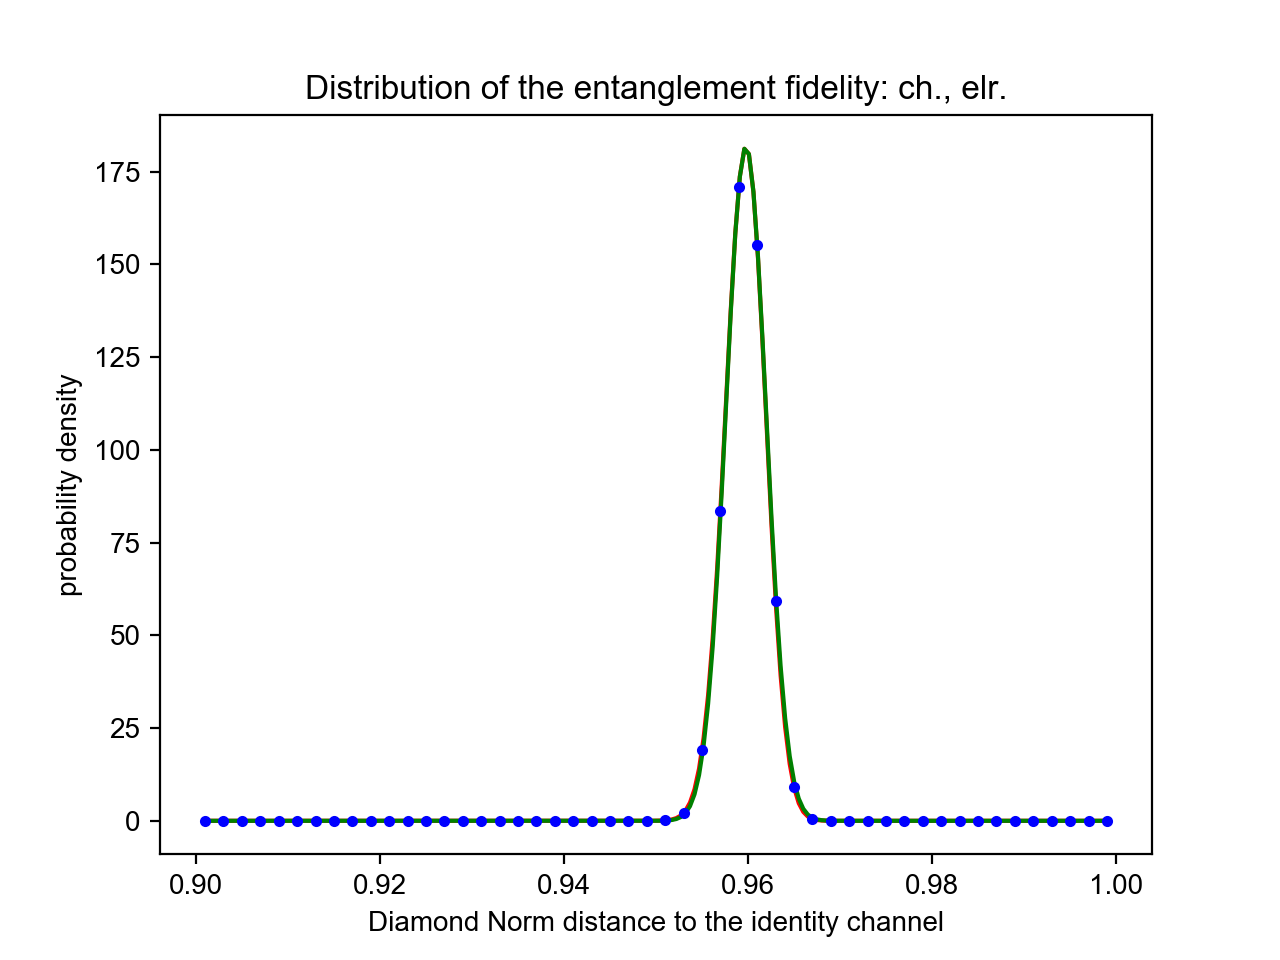

<IPython.core.display.Javascript object>


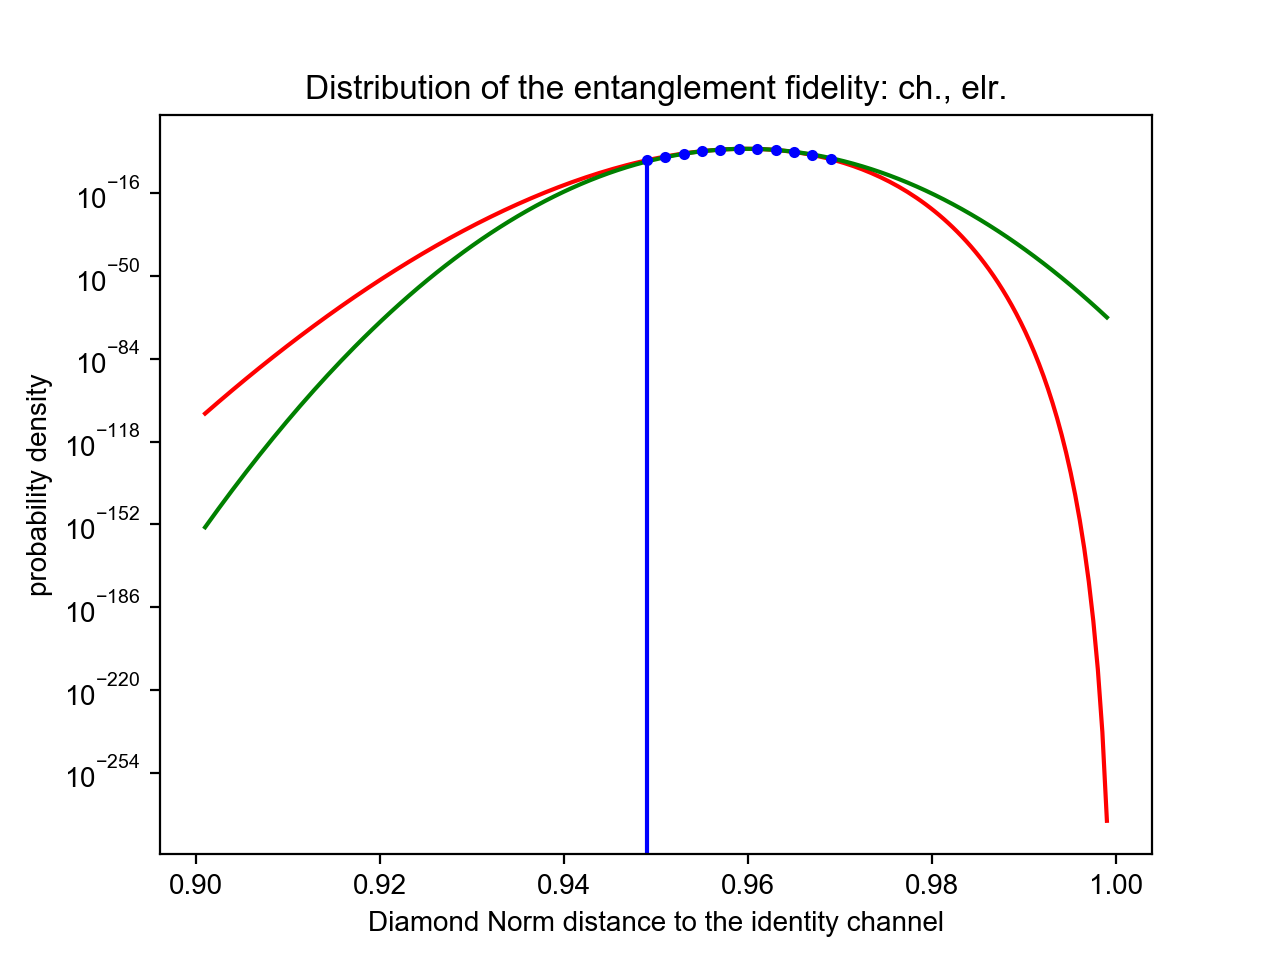

In [36]:
a_Fe_elr = do_analysis(r_Fe_elr, 'ch., elr.', plots=True,
                       qtyname='entanglement fidelity', ftox=(1,-1))

## Channel-space method, "elementary-rotation" variant, worst-case entanglement fidelity

In [20]:
r_wFe_elr = load_from_cache('r_wFe_elr')
if r_wFe_elr is None:
    # no stored result, perform computation
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_wFe_elr = dnormtomo.channelspace.run(
            dimX=2, dimY=2, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
            fig_of_merit='worst-entanglement-fidelity',
            hist_params=tomographer.UniformBinsHistogramParams(0.85, 1.0, 50),
            channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
            mhrw_params=tomographer.MHRWParams(0.02, 50, 2048, 1024),
            progress_fn=prg.progress_fn
            )
        prg.displayFinalInfo(r_wFe_elr['final_report_runs'])
    save_to_cache('r_wFe_elr', r_wFe_elr)
print_report(r_wFe_elr)

Loading `r_wFe_elr` from cache

Calculation ran for **0:00:54.679953 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.02
	# iter. / sweep = 50
	# therm. sweeps = 2048
	# run sweeps    = 1024
#0: 0.85|                           ..+%#%-..              |1                  [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#1: 0.85|                         . ..+%#%-..              |1                  [accept ratio = 0.25]
    error bars: 49 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0.85|                        .  ..+%#%+..              |1                  [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0.85|                           ..o##%+..              |1                  [accept ratio = 0.25]
    error bars: 50 converged / 0 maybe (0 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 0.0176327
          a1 = 3479.33
           m = 193.511
           c = 757.22
Quantum Error Bars:
          f0 = 0.9444
       Delta = 0.005654
       gamma = 0.0001916



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


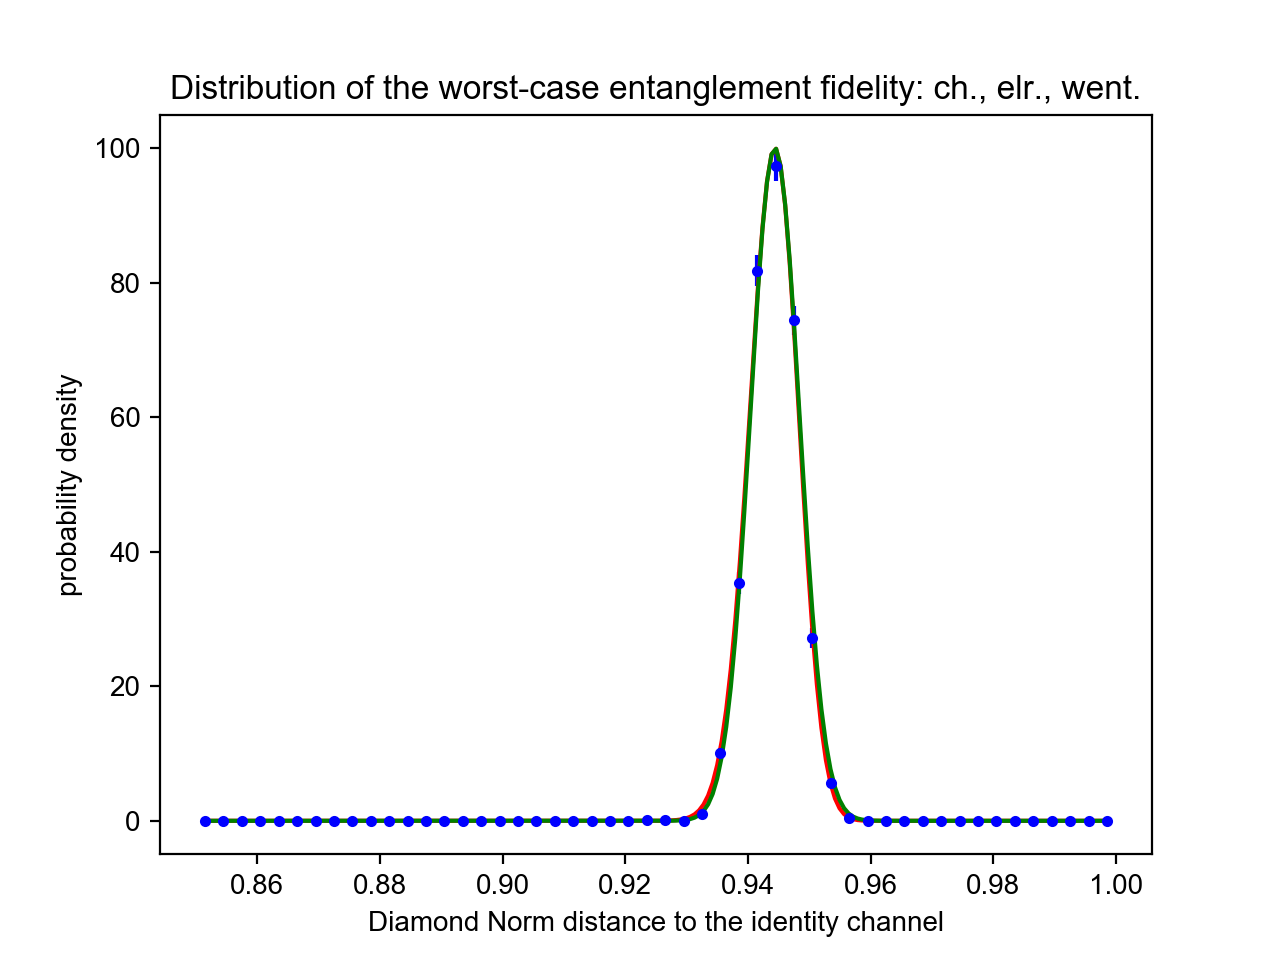

<IPython.core.display.Javascript object>


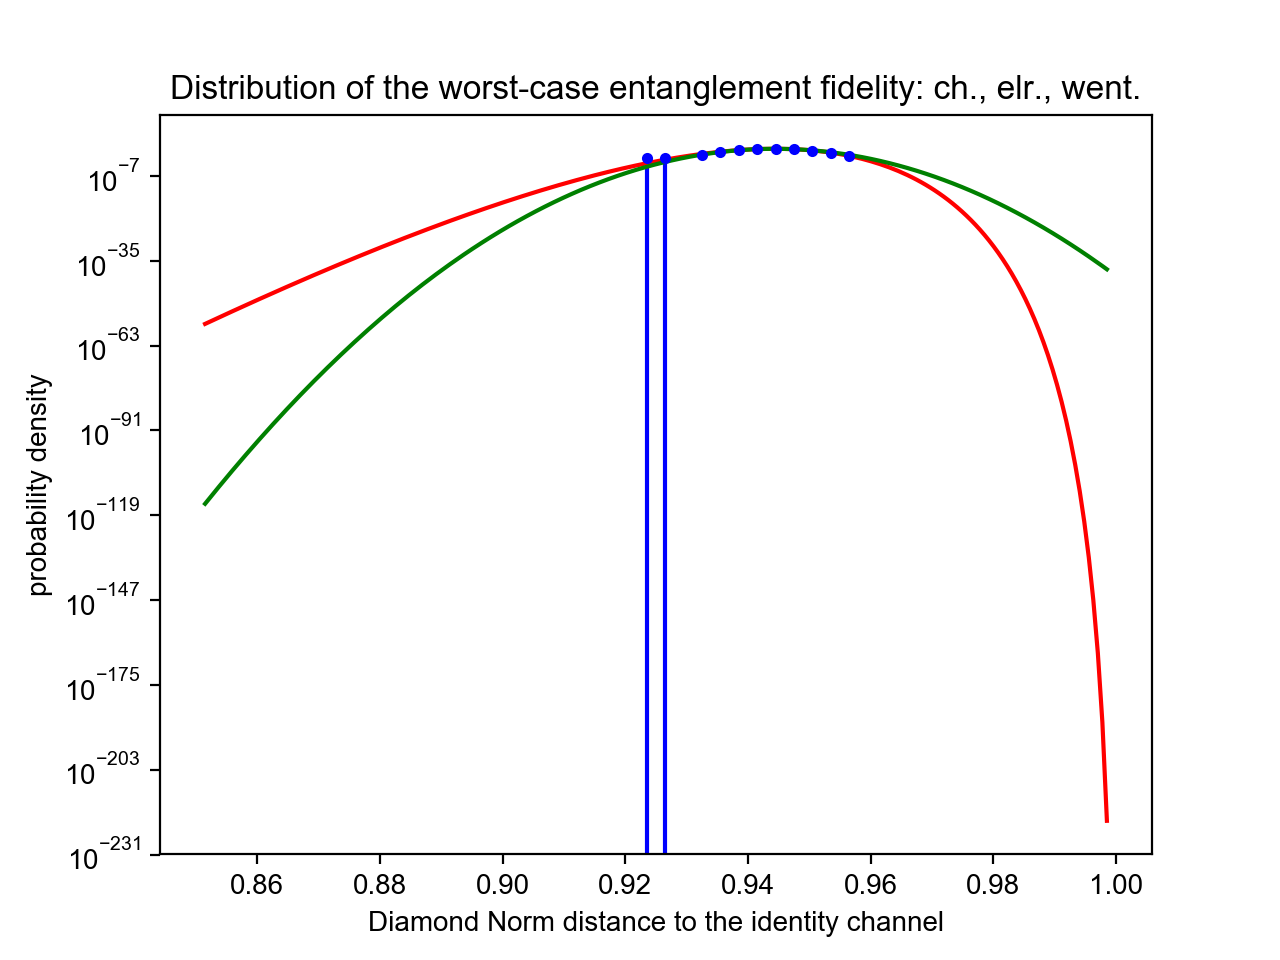

In [44]:
a_wFe_elr = do_analysis(r_wFe_elr, 'ch., elr., went.', plots=True,
                        qtyname='worst-case entanglement fidelity', ftox=(1,-1))

# Grand comparison plots

In [54]:
def do_comparison_plot(alist, fig=None, ax=None, log_scale=False, alt_analysis_args=None, xlabel='', flist=None):

    if fig is None:
        fig, ax = plt.subplots()
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel('probability density')
    
    if log_scale:
        ax.set_yscale('log')
    
    clist = 'crbgmyk'
    
    class _Ns: pass
    thelabels = _Ns()
    thelabels.d = {}
    
    def add_label(s):
        k = len(thelabels.d)
        thelabels.d[k] = s
        return str(k)
    def last_label():
        return thelabels.d.get(len(thelabels.d)-1)
    
    qeb = dict()
    
    for i in range(len(alist)):
        a = alist[i]
        
        print("Taking care of plots for {}".format(a['name']))
        
        r = a['r']
        h = r['final_histogram'].normalized()
        c = clist[i%len(clist)]
        f = h.values_center
        #analysis = a['analysis']
        
        analysis_dflt = tomographer.querrorbars.HistogramAnalysis(h)
        analysis_dflt.printFitParameters()
        qeb[a['name']] = analysis_dflt.printQuantumErrorBars()
        
        analysis = None
        if alt_analysis_args:
            analysis = tomographer.querrorbars.HistogramAnalysis(h, **alt_analysis_args)
            analysis.printFitParameters()
        
        if log_scale:
            ax.errorbar(x=f, y=h.bins, yerr=h.delta, c=c, fmt='.', label=last_label())
        else:
            ax.errorbar(x=f, y=h.bins, yerr=h.delta, c=c, fmt='.', label=add_label('{}, his.'.format(a['name'])))
        
        if flist is None:
            theflist = np.linspace(np.min(f), np.max(f), 100)
        else:
            theflist = flist
        
        plist_dflt = np.exp(analysis_dflt.fit_fn(analysis_dflt.ftox(theflist), *analysis_dflt.fit_params))
        if log_scale:
            ax.plot(theflist, plist_dflt, c=c, ls=':', label=last_label())
        else:
            ax.plot(theflist, plist_dflt, c=c, ls=':', label=add_label('{}, fit1'.format(a['name'])))
        
        
        if analysis is not None:
            plist = np.exp(analysis.fit_fn(analysis.ftox(theflist), *analysis.fit_params))
            if log_scale:
                ax.plot(theflist, plist, c=c, label=last_label())
            else:
                ax.plot(theflist, plist, c=c, label=add_label('{}, fit2'.format(a['name'])))
    
    
    handles, labels = ax.get_legend_handles_labels()
    iorder = sorted(range(len(handles)), key=lambda i: int(labels[i]))
    
    ax.legend([handles[i] for i in iorder], [thelabels.d[int(labels[i])] for i in iorder],fontsize=11)
    
    return dict(qeb=qeb, fig=fig, ax=ax)

### Diamond norm analysis

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


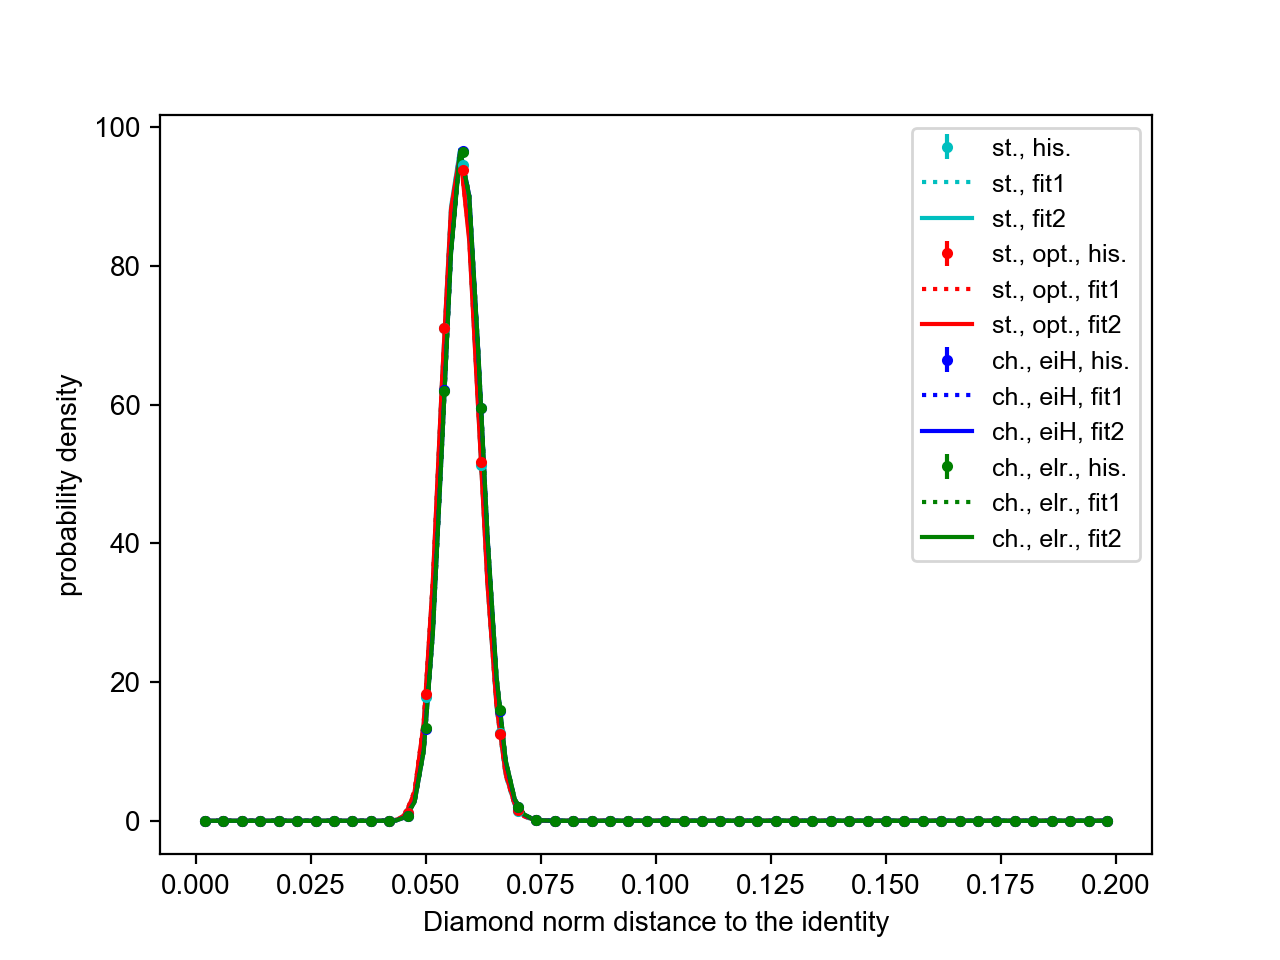

Taking care of plots for st.
Fit parameters:
          a2 = 3.64641e-16
          a1 = 3378.25
           m = 193.345
           c = 751.008
Quantum Error Bars:
          f0 = 0.05723
       Delta = 0.005821
       gamma = 0.0001973



Fit parameters:
           a = 575.954
          xq = -1.84944
           m = 48.8117
           p = 2.46016
           c = 2244.39
Taking care of plots for st., opt.
Fit parameters:
          a2 = 0.0158744
          a1 = 3342.76
           m = 191.305
           c = 743.136
Quantum Error Bars:
          f0 = 0.05723
       Delta = 0.005852
       gamma = 0.0001994



Fit parameters:
           a = 553.22
          xq = -1.87367
           m = 44.4219
           p = 2.53857
           c = 2204.77
Taking care of plots for ch., eiH
Fit parameters:
          a2 = 0.00135496
          a1 = 3428.76
           m = 198.235
           c = 767.881
Quantum Error Bars:
          f0 = 0.05782
       Delta = 0.005807
       gamma = 0.0001944



Fit parameters:
           a = 1038.9
          xq = -1.33889
           m = 184.345
           p = 1.39858
           c = 2373.2
Taking care of plots for ch., elr.
Fit parameters:
          a2 = 3.56162e-10
          a1 = 3421.27
           m = 197.843
           c = 766.328
Quantum Error Bars:
          f0 = 0.05783
       Delta = 0.005814
       gamma = 0.0001949



Fit parameters:
           a = 858.64
          xq = -1.50278
           m = 124.736
           p = 1.68322
           c = 2358.13


In [47]:
def fit_fn_q_lnxp_dnorm(x, a, xq, m, p, c):
    return -a*np.square(x-xq) - m*np.power(-np.log(x)/-np.log(0.16), p) + c

xyz = do_comparison_plot([a_naive, a_naiveopt, a_eiH, a_elr], log_scale=False,
                         alt_analysis_args=dict(fit_fn=fit_fn_q_lnxp_dnorm, maxfev=10000,
                                                bounds=((0,-np.inf,0,0,-np.inf),np.inf),
                                                p0=(12, -13, 0.057, 8.8, 2100),),
                         xlabel='Diamond norm distance to the identity')

plt.show()

### Entanglement fidelity & worst-case entanglement fidelity analysis

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


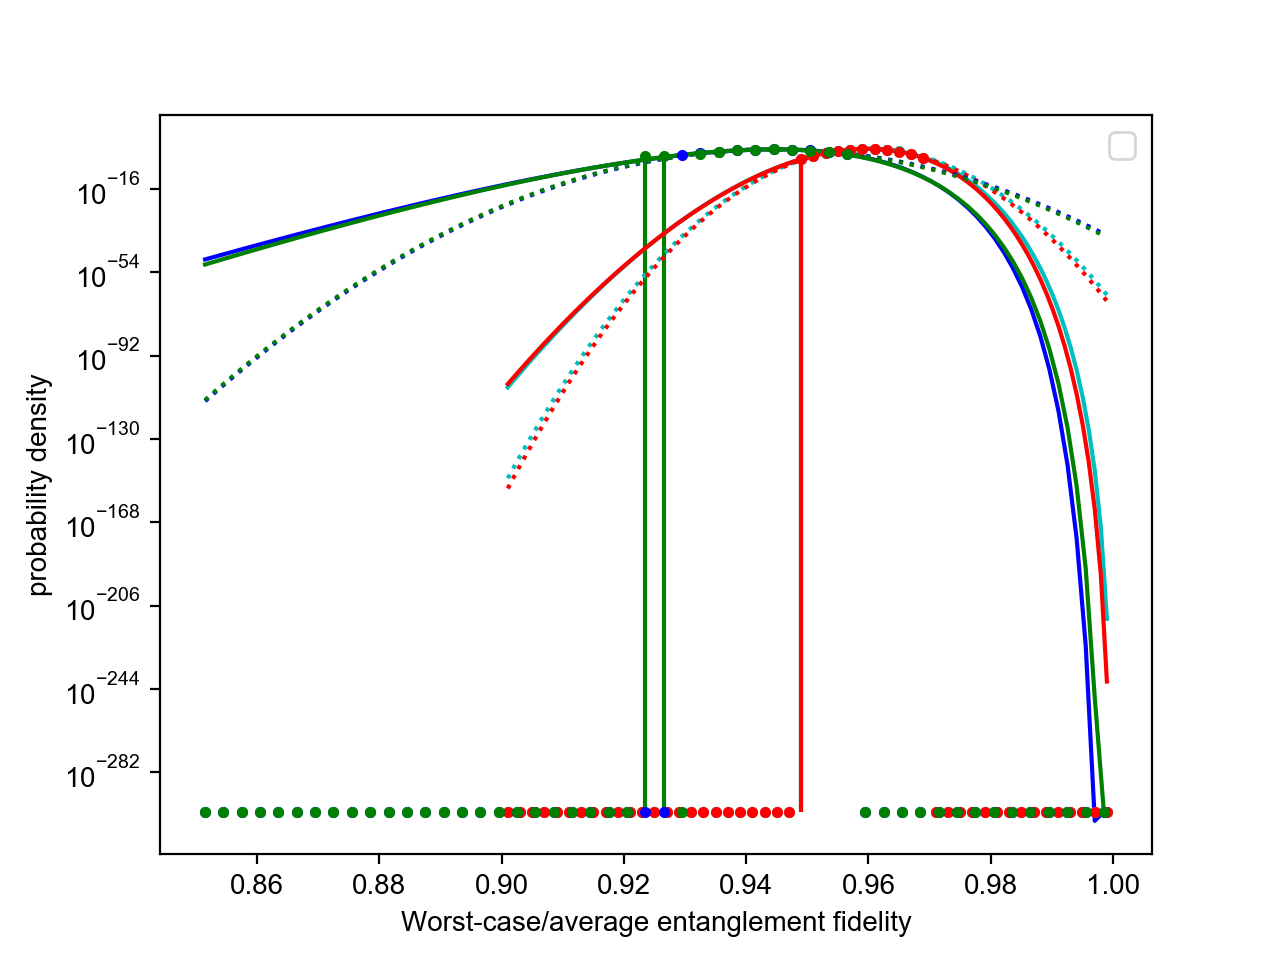

Taking care of plots for st., opt.
Fit parameters:
          a2 = 99726.1
          a1 = -191005
           m = 416.563
           c = -91435.3
Quantum Error Bars:
          f0 = 0.9598
       Delta = 0.003163
       gamma = 7.859e-09



Fit parameters:
           a = 38697.4
          xq = -0.0474368
           m = 6939.58
           p = 0.118324
           c = 7688.6
Taking care of plots for ch., elr.
Fit parameters:
          a2 = 103452
          a1 = -198455
           m = 107.961
           c = -95165
Quantum Error Bars:
          f0 = 0.9597
       Delta = 0.003108
       gamma = 1.9e-09



Fit parameters:
           a = 32586.7
          xq = -0.0795315
           m = 6638.51
           p = 0.141085
           c = 7623.41
Taking care of plots for st., opt., went.
Fit parameters:
          a2 = 30514.9
          a1 = -57641.6
           m = 5.3441
           c = -27215.8
Quantum Error Bars:
          f0 = 0.9446
       Delta = 0.005724
       gamma = 1.135e-09



Fit parameters:
           a = 995.322
          xq = -0.886752
           m = 22.8719
           p = 3.27061
           c = 979.035
Taking care of plots for ch., elr., went.
Fit parameters:
          a2 = 30607.5
          a1 = -57669.4
           m = 117.655
           c = -27153.2
Quantum Error Bars:
          f0 = 0.9441
       Delta = 0.00571
       gamma = 2.477e-08



Fit parameters:
           a = 755.425
          xq = -1.40492
           m = 47.1644
           p = 2.55884
           c = 1754.43


In [51]:
def fit_fn_q_lnxp_Fe(x, a, xq, m, p, c):
    return -a*np.square(x-xq) - m*np.power(-np.log(x)/-np.log(0.15), p) + c

xyz = do_comparison_plot([a_Fe_naiveopt, a_Fe_elr, a_wFe_naiveopt, a_wFe_elr],log_scale=True,
                         alt_analysis_args=dict(fit_fn=fit_fn_q_lnxp_Fe, maxfev=1000000, ftox=(1,-1),
                                                bounds=((0,-np.inf,0,0,-np.inf),np.inf),
                                               ),
                         xlabel='Worst-case/average entanglement fidelity')

plt.show()

# Generate plots for the paper

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


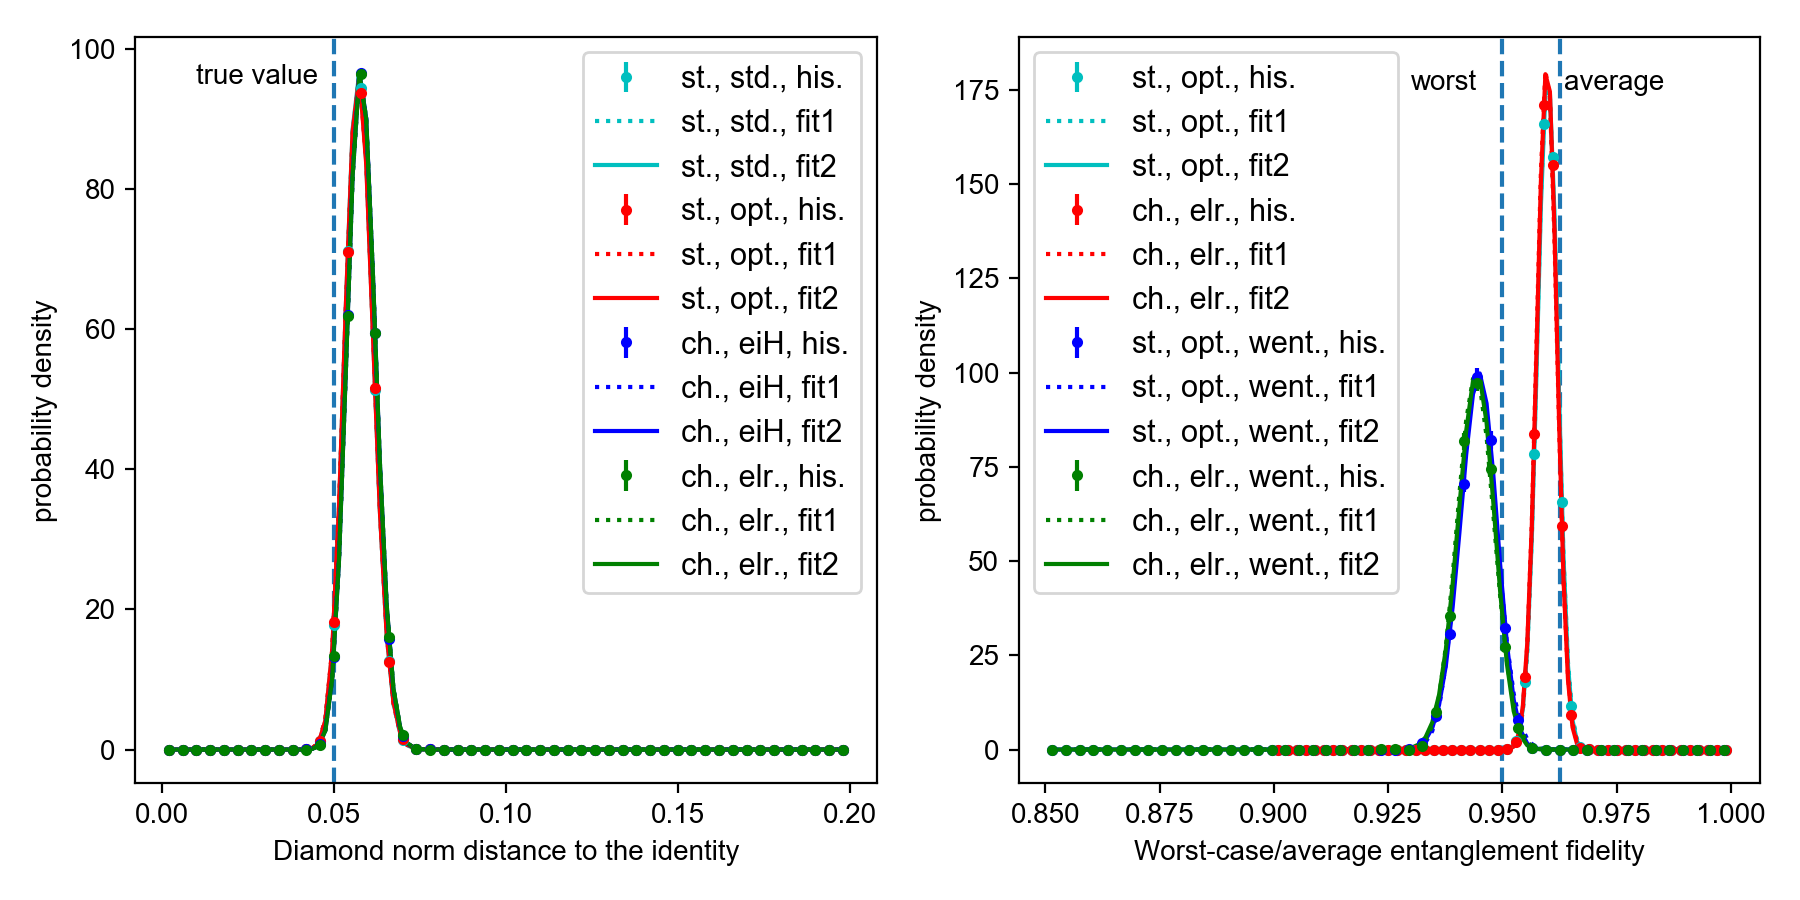

Taking care of plots for st., std.
Fit parameters:
          a2 = 3.64641e-16
          a1 = 3378.25
           m = 193.345
           c = 751.008
Quantum Error Bars:
          f0 = 0.05723
       Delta = 0.005821
       gamma = 0.0001973



Fit parameters:
           a = 575.954
          xq = -1.84944
           m = 48.8117
           p = 2.46016
           c = 2244.39
Taking care of plots for st., opt.
Fit parameters:
          a2 = 0.0158744
          a1 = 3342.76
           m = 191.305
           c = 743.136
Quantum Error Bars:
          f0 = 0.05723
       Delta = 0.005852
       gamma = 0.0001994



Fit parameters:
           a = 553.22
          xq = -1.87367
           m = 44.4219
           p = 2.53857
           c = 2204.77
Taking care of plots for ch., eiH
Fit parameters:
          a2 = 0.00135496
          a1 = 3428.76
           m = 198.235
           c = 767.881
Quantum Error Bars:
          f0 = 0.05782
       Delta = 0.005807
       gamma = 0.0001944



Fit parameters:
           a = 1038.9
          xq = -1.33889
           m = 184.345
           p = 1.39858
           c = 2373.2
Taking care of plots for ch., elr.
Fit parameters:
          a2 = 3.56162e-10
          a1 = 3421.27
           m = 197.843
           c = 766.328
Quantum Error Bars:
          f0 = 0.05783
       Delta = 0.005814
       gamma = 0.0001949



Fit parameters:
           a = 858.64
          xq = -1.50278
           m = 124.736
           p = 1.68322
           c = 2358.13
Taking care of plots for st., opt.
Fit parameters:
          a2 = 99726.1
          a1 = -191005
           m = 416.563
           c = -91435.3
Quantum Error Bars:
          f0 = 0.9598
       Delta = 0.003163
       gamma = 7.859e-09



Fit parameters:
           a = 38678.2
          xq = -0.0475036
           m = 6934.5
           p = 0.118435
           c = 7683.93
Taking care of plots for ch., elr.
Fit parameters:
          a2 = 103452
          a1 = -198455
           m = 107.961
           c = -95165
Quantum Error Bars:
          f0 = 0.9597
       Delta = 0.003108
       gamma = 1.9e-09



Fit parameters:
           a = 32587.1
          xq = -0.0795345
           m = 6643.71
           p = 0.140987
           c = 7628.67
Taking care of plots for st., opt., went.
Fit parameters:
          a2 = 30514.9
          a1 = -57641.6
           m = 5.3441
           c = -27215.8
Quantum Error Bars:
          f0 = 0.9446
       Delta = 0.005724
       gamma = 1.135e-09



Fit parameters:
           a = 946.169
          xq = -0.940364
           m = 23.2481
           p = 3.25473
           c = 1034.59
Taking care of plots for ch., elr., went.
Fit parameters:
          a2 = 30607.5
          a1 = -57669.4
           m = 117.655
           c = -27153.2
Quantum Error Bars:
          f0 = 0.9441
       Delta = 0.00571
       gamma = 2.477e-08



Fit parameters:
           a = 718.452
          xq = -1.4857
           m = 47.7538
           p = 2.54806
           c = 1850.89


In [57]:
compare_fig = plt.figure(figsize=(9,4.5))
ax1 = compare_fig.add_subplot(121)
ax2 = compare_fig.add_subplot(122)


# Overlay the true value of the figure of merit
import dnormtomo.figofmerit as figofmerit
Delta = Ereal_XY.full()-np.array([[ 1, 0, 0, 1],
                                  [ 0, 0, 0, 0],
                                  [ 0, 0, 0, 0],
                                  [ 1, 0, 0, 1]])
true_dnorm = figofmerit.diamond_norm_dist(Delta,2)
true_avgentglfid = figofmerit.avg_entgl_fidelity2(Ereal_XY.full(),2)
true_worstentglfid = figofmerit.worst_entgl_fidelity2(Ereal_XY.full(),2)

ax1.axvline(true_dnorm, linestyle='dashed')
ax1.text(true_dnorm-0.04,95,'true value')
ax2.axvline(true_avgentglfid, linestyle='dashed')
ax2.text(true_avgentglfid+0.001,175,'average')
ax2.axvline(true_worstentglfid, linestyle='dashed')
ax2.text(true_worstentglfid-0.02,175,'worst')


# Then plot the diamond norm figure of merit
def fit_fn_q_lnxp_dnorm(x, a, xq, m, p, c):
    return -a*np.square(x-xq) - m*np.power(-np.log(x)/-np.log(0.16), p) + c

qeb_dnorms, fig, ax1 = do_comparison_plot([a_naive, a_naiveopt, a_eiH, a_elr], fig, ax1, log_scale=False,
                         alt_analysis_args=dict(fit_fn=fit_fn_q_lnxp_dnorm, maxfev=10000,
                                                bounds=((0,-np.inf,0,0,-np.inf),np.inf),
                                                p0=(12, -13, 0.057, 8.8, 2100),),
                         xlabel='Diamond norm distance to the identity')

# Now plot the entanglement fidelities
def fit_fn_q_lnxp_Fe(x, a, xq, m, p, c):
    return -a*np.square(x-xq) - m*np.power(-np.log(x)/-np.log(0.15), p) + c


qeb_fidelities, fig, ax2 = do_comparison_plot([a_Fe_naiveopt, a_Fe_elr, a_wFe_naiveopt, a_wFe_elr], fig, ax2, log_scale=False,
                         alt_analysis_args=dict(fit_fn=fit_fn_q_lnxp_Fe, maxfev=1000000, ftox=(1,-1),
                                                bounds=((0,-np.inf,0,0,-np.inf),np.inf),
                                               ),
                         xlabel='Worst-case/average entanglement fidelity')
compare_fig.tight_layout()
compare_fig.savefig('compare.pdf',format='pdf')

## Typical output: diamond norm to identity, channel space elementary rotation

Fit parameters:
          a2 = 3.56162e-10
          a1 = 3421.27
           m = 197.843
           c = 766.328
Quantum Error Bars:
          f0 = 0.05783
       Delta = 0.005814
       gamma = 0.0001949



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


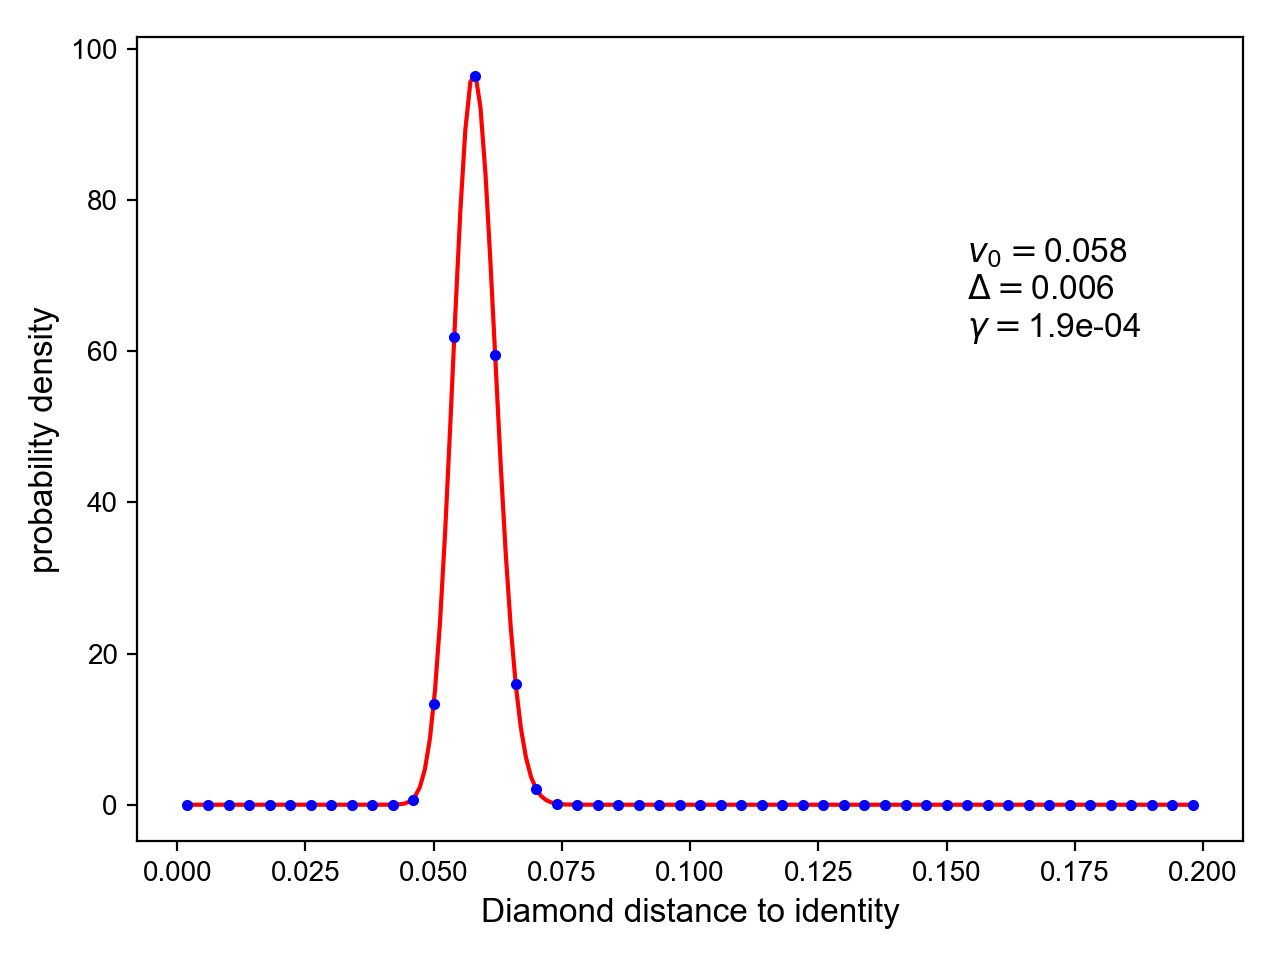

In [58]:
r = r_elr
name = 'channel space elementary rotation'
plots = True
ftox = (0,1)
qtyname = 'Diamond distance to identity'

final_histogram = r['final_histogram']
analysis = tomographer.querrorbars.HistogramAnalysis(final_histogram, ftox=ftox)
fitparams = analysis.printFitParameters()
qeb = analysis.printQuantumErrorBars()
    
p1 = None
p2 = None

if plots:
    # build a rectangle in axes coords
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height 
    
    # linear scale
    p = analysis.plot(xlabel=qtyname, plot_deskewed_gaussian=False,show_plot=False, fontsize=16)
    p.ax.text(right, top, "$v_0=${:.3f}\n$\\Delta=${:.3f}\n$\\gamma=${:.1e}".format(qeb.f0, qeb.Delta, qeb.gamma), fontsize=12, horizontalalignment='left', verticalalignment='top', transform=p.ax.transAxes)
    p.show()
    
#return {'r': r, 'name': name, 'analysis': analysis, 'fitparams': fitparams, 'p1': p1, 'p2': p2}
p.ax.set_xlabel(qtyname, fontsize=12)
p.ax.set_ylabel('probability density', fontsize=12)
p.fig.tight_layout()
p.fig.savefig('typical_output.pdf',format='pdf')

## Obtaining confidence interval for diamond norm

In [27]:
import scipy as sp
def diamonddistance_region(n,d,epsilon,doAnalysis):
    analysis = doAnalysis['analysis']
    def density(f):
        return np.exp(analysis.fit_fn(analysis.ftox(f),*analysis.fit_params))
    def log10_tail_cumulative(v):
        value, error = sp.integrate.quad(density,v,1)
        return np.log10(value)
    def tail_cumulative(v):
        value, error = sp.integrate.quad(density,v,1)
        return (value-10.**(-500))
    def epsilon_prime(epsilon,n,d):
        return np.log10(epsilon/2)-2*(d**2-1)*np.log10(2*n+1)
    def find_region(vlist,ylist,epsilon_prime):
        index = next(x[0] for x in enumerate(ylist) if x[1] < epsilon_prime)
        return vlist[index]
    vlist = np.linspace(0,1,10000)
    ylist = [log10_tail_cumulative(vlist[i]) for i in range(0,len(vlist))]
    plt.figure()
    plt.plot(vlist,ylist)
    plt.show()
    epsprime = epsilon_prime(epsilon,n,d)
    print('epsilon_prime:', epsprime)
    vthres = find_region(vlist,ylist,epsprime)
    print('threshold: ', vthres)
    def delta(e,n,d):
        return np.sqrt(2/n*(np.log10(2/e)+3*(d**2-1)*np.log10(2*n+1)))
    de = delta(epsilon,n,d)
    venlarge = 2*de/2
    print('enlarge:', venlarge)
    return vthres+venlarge

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


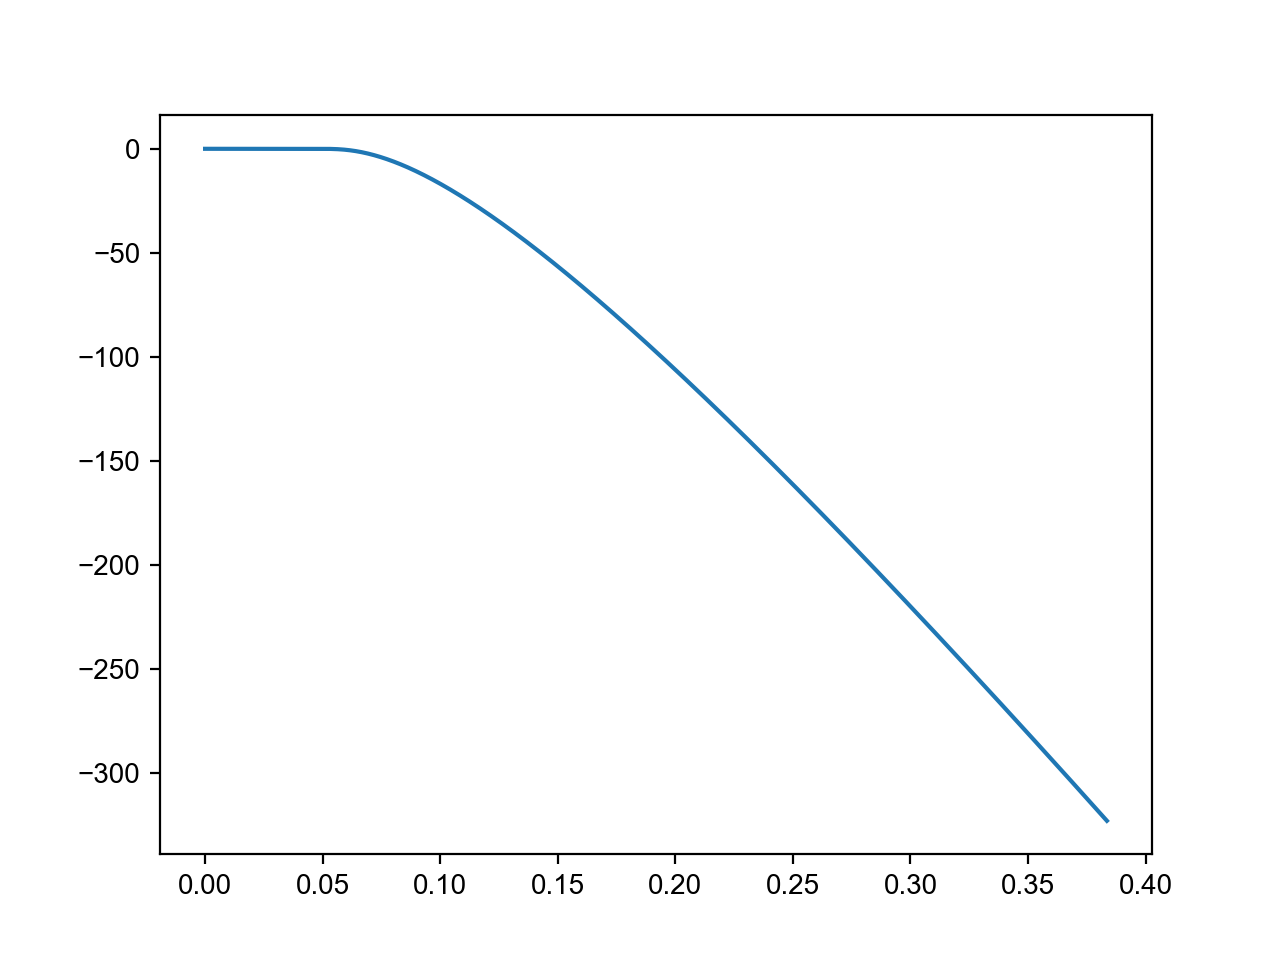

epsilon_prime: -150.928450043
threshold:  0.240924092409
enlarge: 0.100053798877


0.3409778912857494

In [28]:
diamonddistance_region(n=45000,d=4,epsilon=10**(-2), doAnalysis=a_elr)

## behavior of $\mu(f)$ for larger values of f.

Note: We need to evaluate everything in log space or we get overflows.

Fit parameters:
          a2 = 103452
          a1 = -198455
           m = 107.961
           c = -95165
Quantum Error Bars:
          f0 = 0.9597
       Delta = 0.003108
       gamma = 1.9e-09



/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


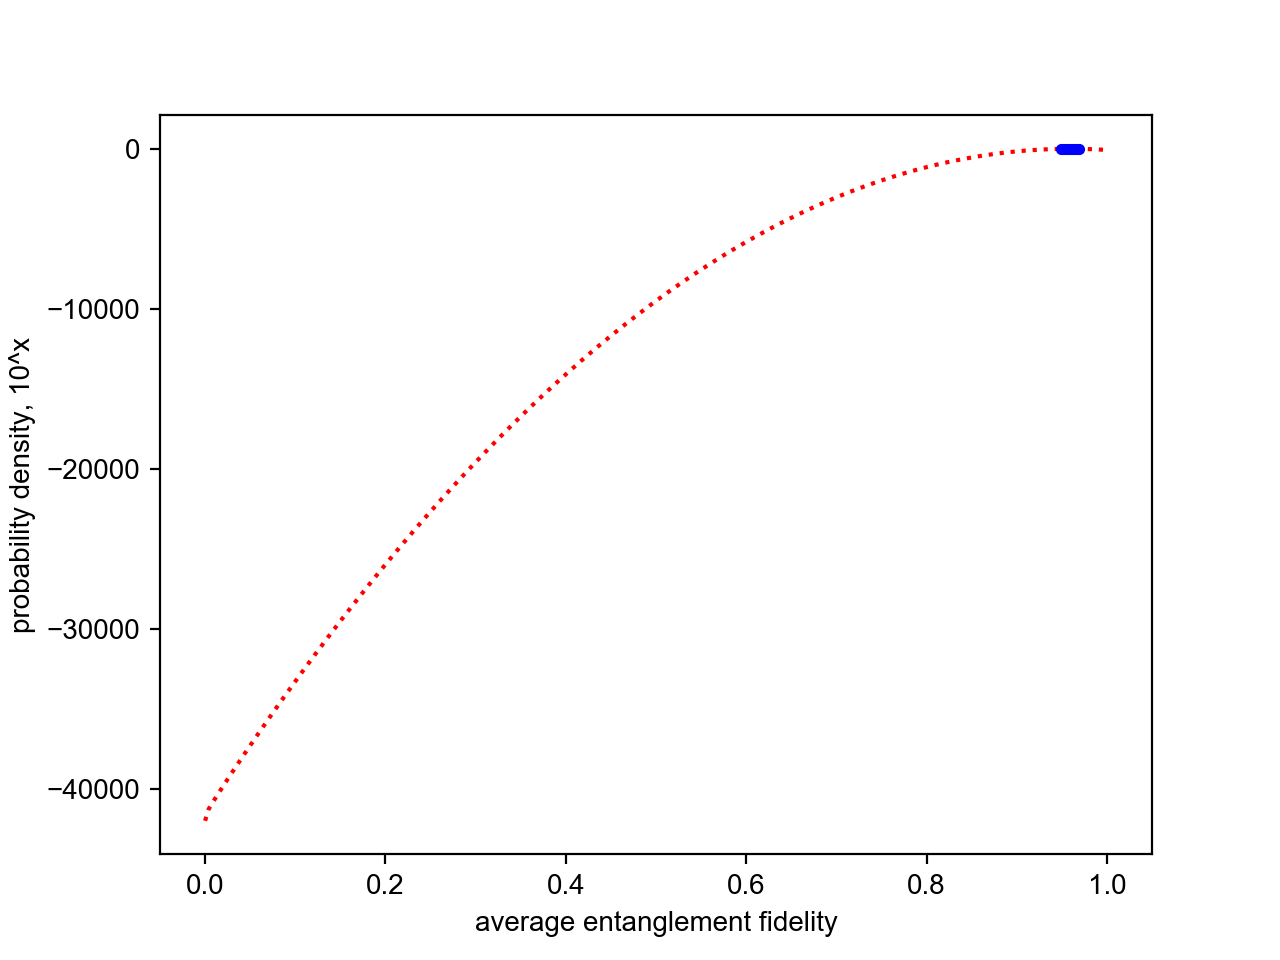

In [29]:
# normalized histogram
hn = r_Fe_elr['final_histogram'].normalized()

analysis_dflt_elr = tomographer.querrorbars.HistogramAnalysis(hn)
analysis_dflt_elr.printFitParameters()
analysis_dflt_elr.printQuantumErrorBars()
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('average entanglement fidelity')
ax.set_ylabel('probability density, 10^x')

f = hn.values_center

# careful between log10() and ln()=log()
idx = np.nonzero(hn.bins)
ax.errorbar(x=f[idx], y=np.log10(hn.bins[idx]),
            yerr=np.divide(hn.delta[idx], hn.bins[idx])/np.log(10), c='b', fmt='.')

theflist = np.linspace(1e-6, 1, 256)
y1 = analysis_dflt_elr.fit_fn(analysis_dflt_elr.ftox(theflist),
                              *analysis_dflt_elr.fit_params)/np.log(10.0)
ax.plot(theflist, y1, c='r', ls=':')

plt.show()

Fit parameters:
          a2 = 22.6545
          a1 = 35.1608
           m = 7.37103e-16
           p = 32.133
           c = 6.68901


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


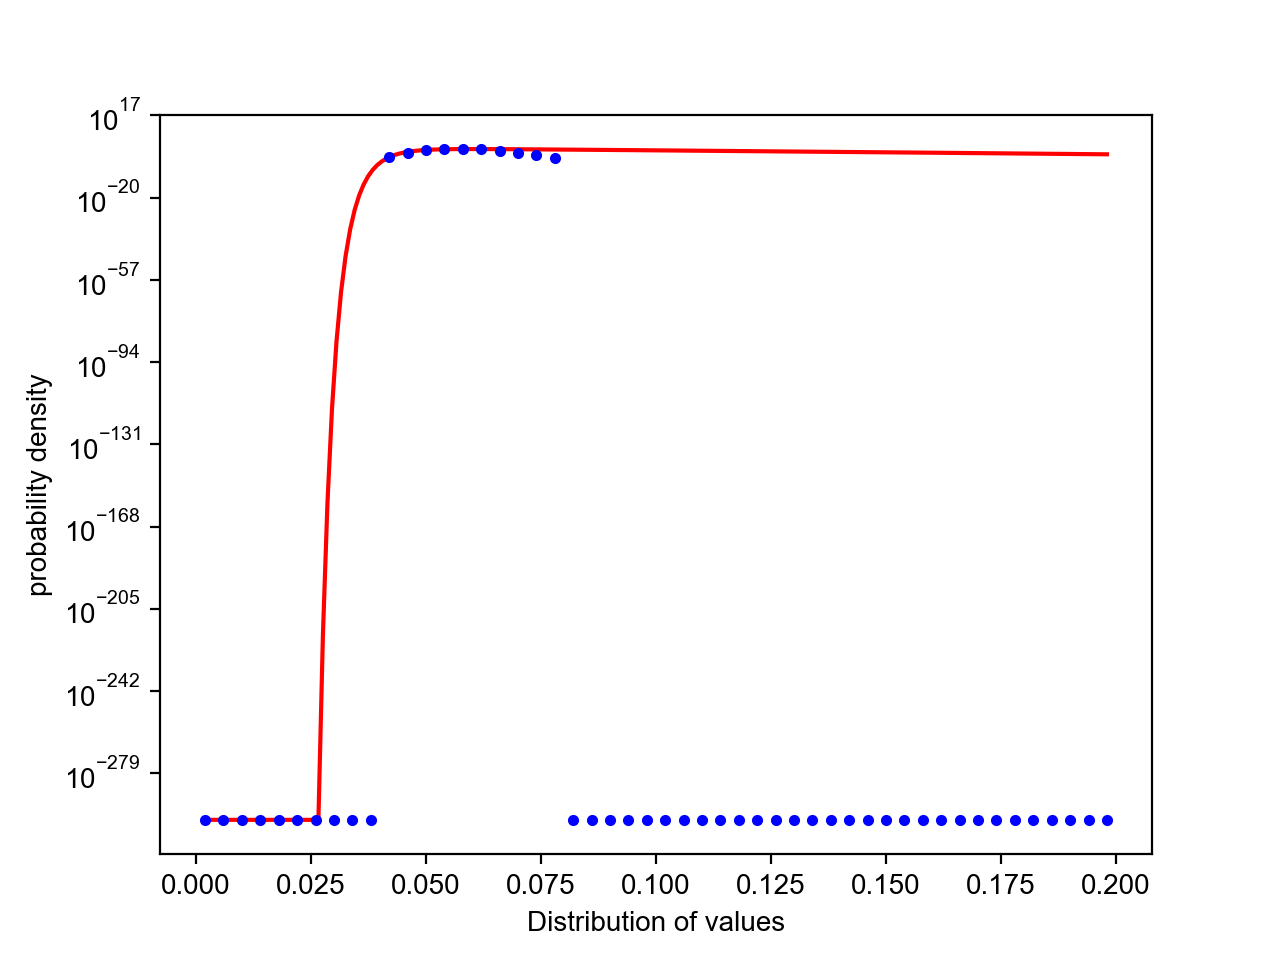

In [30]:
def fit_fn_test(x, a2, a1, m, p, c):
    return -a2* np.square(x) - a1*x - m*np.power(-np.log(x),p) + c
    
a = tomographer.querrorbars.HistogramAnalysis(
    r_naiveopt['final_histogram'], fit_fn=fit_fn_test, bounds=((0,-np.inf,0,0,-np.inf), np.inf)
)
a.printFitParameters()
a.plot(plot_deskewed_gaussian=False, log_scale=True)